# ARIMA/SARIMA while handling outliers with different techniques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from scipy.stats import zscore
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Load data
data = pd.read_csv(r"/content/financial_data.csv")
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)
data = data.asfreq('D')
data['Price'].fillna(method='ffill', inplace=True)

# Sarima Hyperparameter Tuning

Examples of parameter combinations for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 30)
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 2) x (0, 0, 1, 30)
SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:2547.09682291446
SARIMA(0, 0, 0)x(0, 0, 0, 30) - AIC:2547.09682291446
SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:2406.676753125345
SARIMA(0, 0, 0)x(0, 0, 1, 30) - AIC:1901.183061218715
SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:2465.403104533302
SARIMA(0, 0, 0)x(0, 1, 0, 30) - AIC:1926.9387308923058
SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:2262.586908996169
SARIMA(0, 0, 0)x(0, 1, 1, 30) - AIC:2547.6239025085983
SARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:2426.740926071533
SARIMA(0, 0, 0)x(1, 0, 0, 30) - AIC:1940.8975009058038
SARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:2399.05772633967
SARIMA(0, 0, 0)x(1, 0, 1, 30) - AIC:1871.7503415947551
SARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:2310.6965756145655
SARIMA(0, 0, 0)x(1, 1, 0, 30) - AIC:1245.8320119331547
SARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:2262.905091914968
SARIMA(0, 0, 0)x(1, 1, 1, 30) - AIC:1254.5

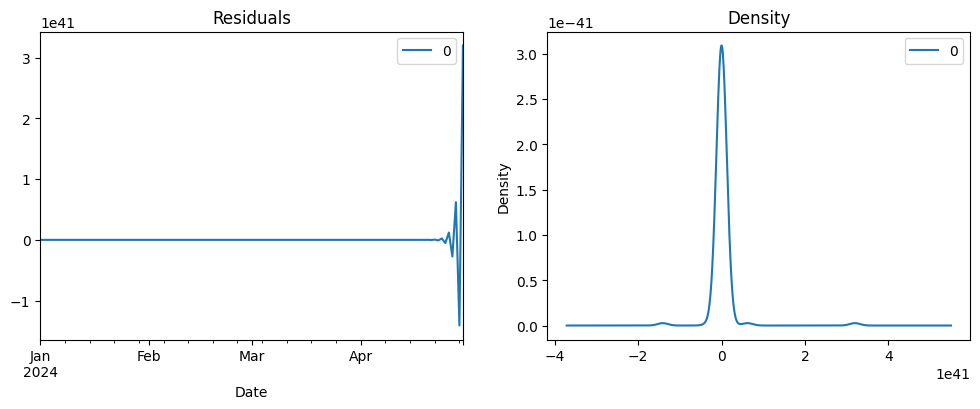

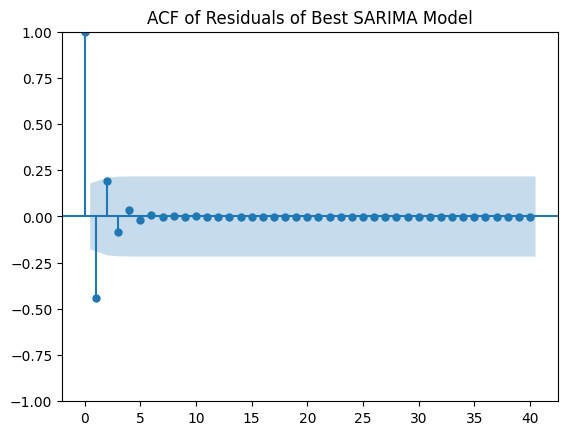

In [3]:
import itertools

# Define the ranges for p, d, q, P, D, Q, and s
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = [7,30]

# Generate all different combinations of p, d, q and P, D, Q, s
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))

print('Examples of parameter combinations for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))

warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_params = None
best_model = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(data['Price'],
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            results = model.fit(disp=False)

            print(f'SARIMA{param}x{seasonal_param} - AIC:{results.aic}')

            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, seasonal_param)
                best_model = results

        except Exception as e:
            print(f'SARIMA{param}x{seasonal_param} - Error: {e}')
            continue

print('\nBest SARIMA model:')
print(f'SARIMA{best_params} - AIC:{best_aic}')
print(best_model.summary().tables[1])

# Analyze the residuals of the best model
residuals = pd.DataFrame(best_model.resid)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=40, title="ACF of Residuals of Best SARIMA Model")
plt.show()

# SARIMA with outlier detection and handling

# Isolation Forest+ winsorization_95

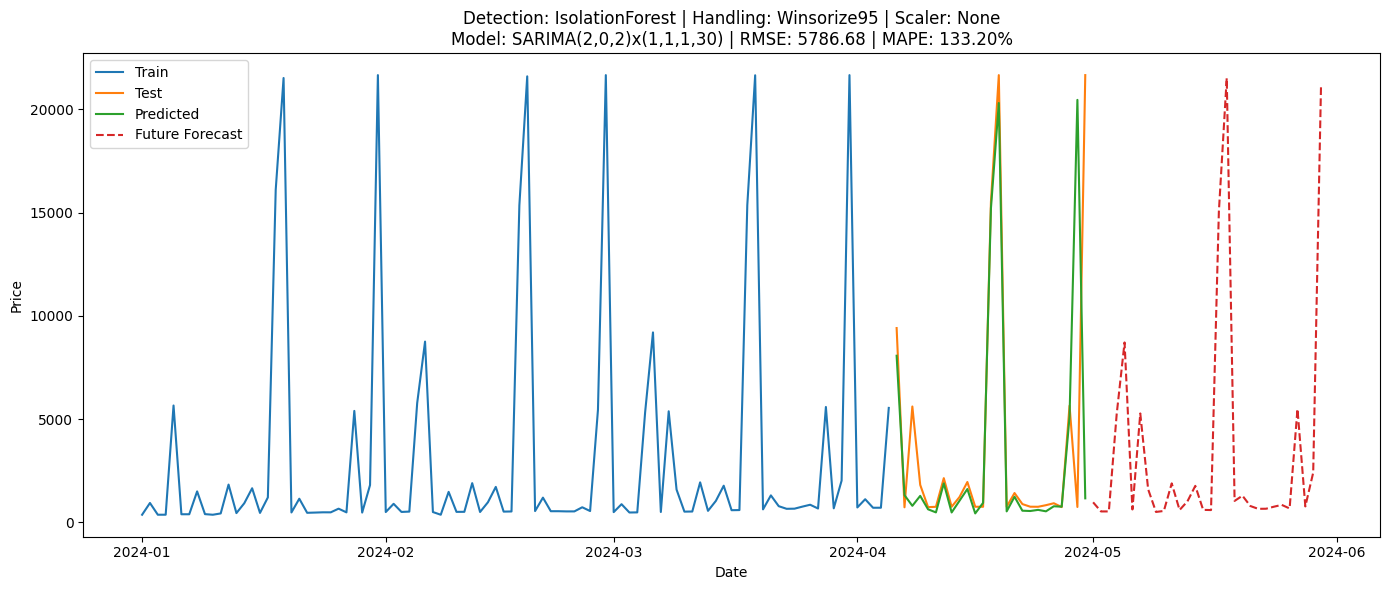

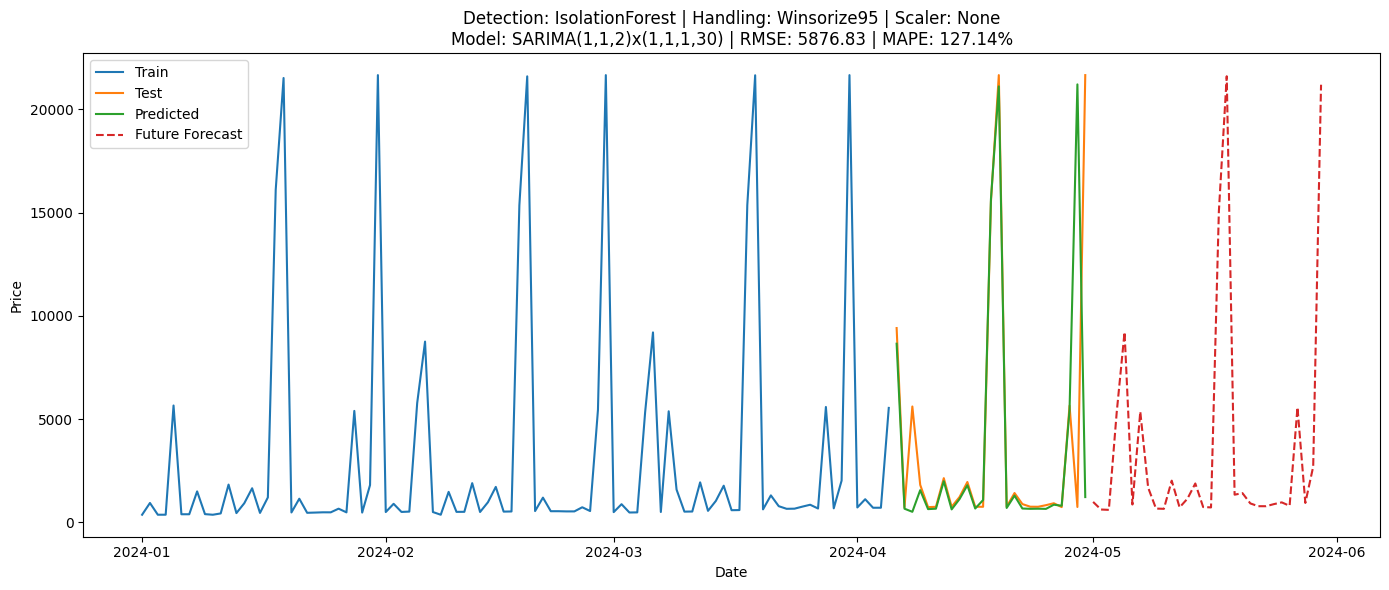


============= Final Results: IsolationForest + Winsorize95 =============
                   Model    RMSE   MAPE
SARIMA(2,0,2)x(1,1,1,30) 5786.68 133.20
SARIMA(1,1,2)x(1,1,1,30) 5876.83 127.14


In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

# Outlier detection: Isolation Forest
def detect_outliers_isolation_forest(data):
    clf = IsolationForest(contamination=0.01, random_state=42)
    preds = clf.fit_predict(data.values.reshape(-1, 1))
    return preds == -1  # boolean mask of outliers

# Outlier handling: Winsorize (95%)
def handle_outliers(data, outliers, method="winsorize_95"):
    cleaned = data.copy()
    if method == "winsorize_95":
        lower = np.percentile(cleaned[~outliers], 2.5)
        upper = np.percentile(cleaned[~outliers], 97.5)
        return np.clip(cleaned, lower, upper)
    return cleaned

# Model configurations
model_configs = {
    "SARIMA(2,0,2)x(1,1,1,30)": (SARIMAX, (2, 0, 2), (1, 1, 1, 30)),
     "SARIMA(1,1,2)x(1,1,1,30)": (SARIMAX, (1, 1, 2), (1, 1, 1, 30))
}

# Step 1: Detect outliers
values = data['Price'].copy()
outliers = detect_outliers_isolation_forest(values)

# Step 2: Handle outliers
cleaned_data = handle_outliers(values, outliers, method="winsorize_95")

# Step 3: Train-test split (no scaling)
series = cleaned_data.copy()
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]
train_index = data.index[:train_size]
test_index = data.index[train_size:]
future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Step 4: Model fitting, prediction, and forecasting
results = []

for model_name, (model_class, order, seasonal_order) in model_configs.items():
    try:
        model = model_class(train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False).fit()

        pred_test = model.forecast(steps=len(test))
        rmse = sqrt(mean_squared_error(test, pred_test))
        mape = mean_absolute_percentage_error(test, pred_test)

        # Forecast next 30 days
        future_forecast = model.forecast(steps=len(test) + 30)[-30:]

        # Plot results
        plt.figure(figsize=(14, 6))
        plt.plot(train_index, train, label='Train')
        plt.plot(test_index, test, label='Test')
        plt.plot(test_index, pred_test, label='Predicted')
        plt.plot(future_index, future_forecast, label='Future Forecast', linestyle='--')

        title = f"Detection: IsolationForest | Handling: Winsorize95 | Scaler: None\nModel: {model_name} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%"
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.tight_layout()
        plt.show()

        results.append({
            "Model": model_name,
            "RMSE": round(rmse, 2),
            "MAPE": round(mape, 2)
        })

    except Exception as e:
        print(f"Model {model_name} failed: {e}")

# Step 5: Show summary
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\n============= Final Results: IsolationForest + Winsorize95 =============")
print(results_df.to_string(index=False))

# Z-score,Std + winsorize and rolling median window =3

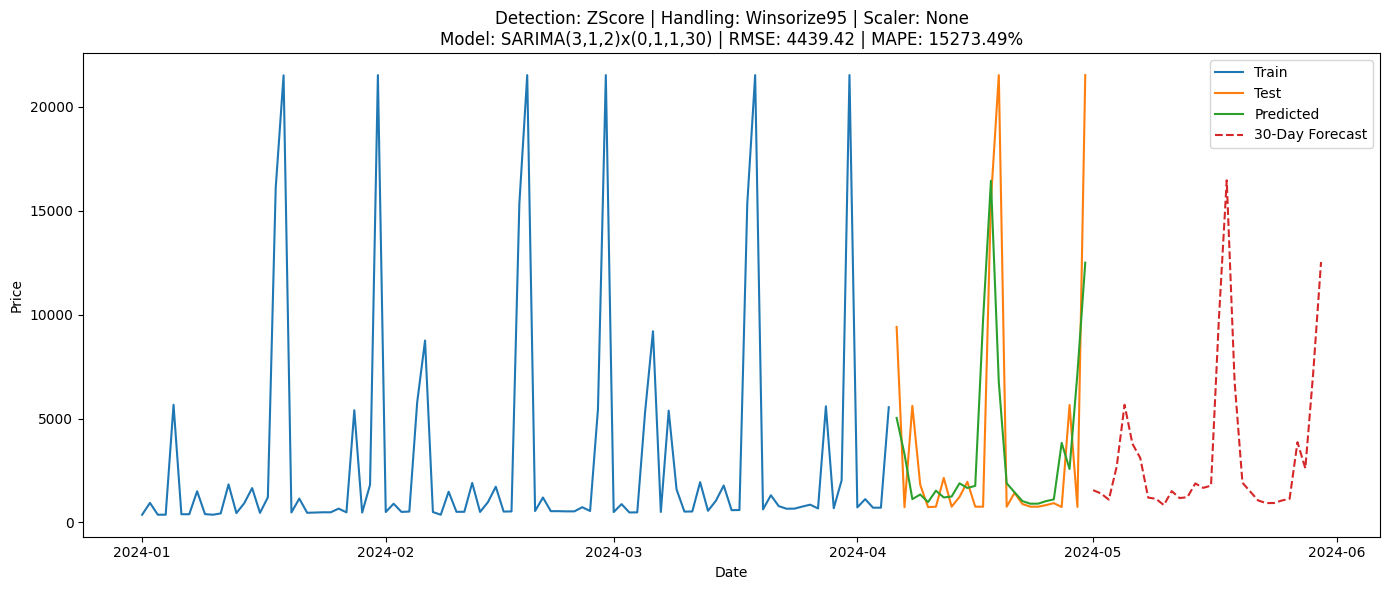

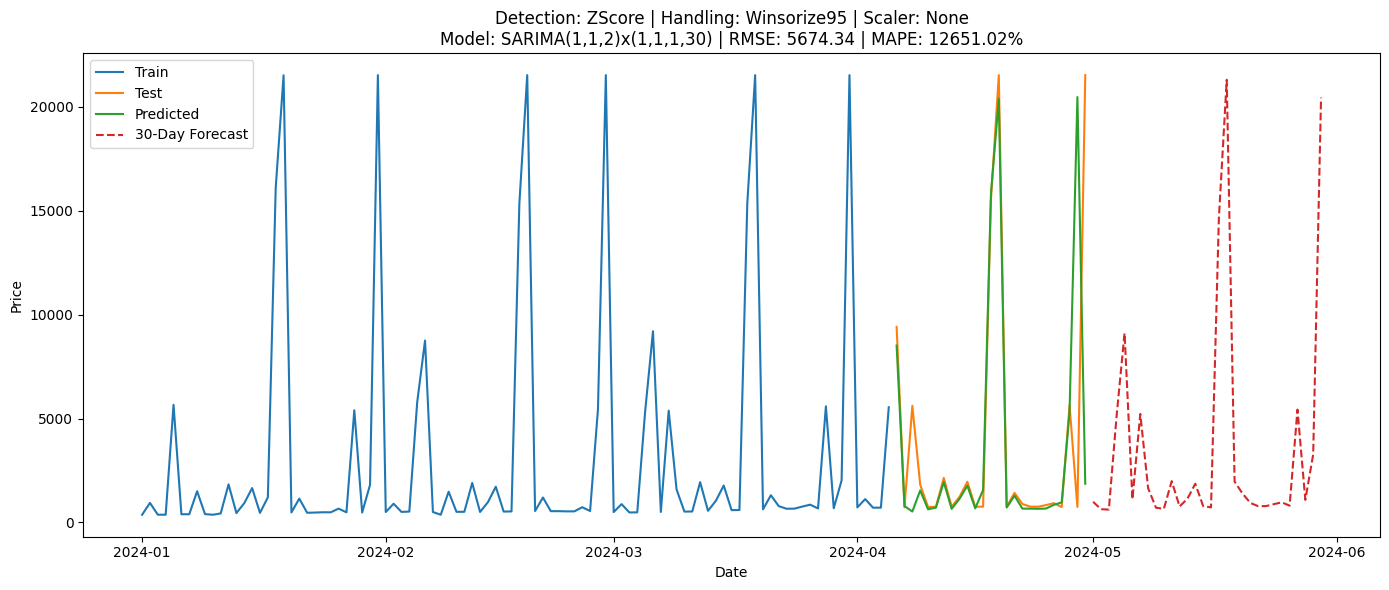

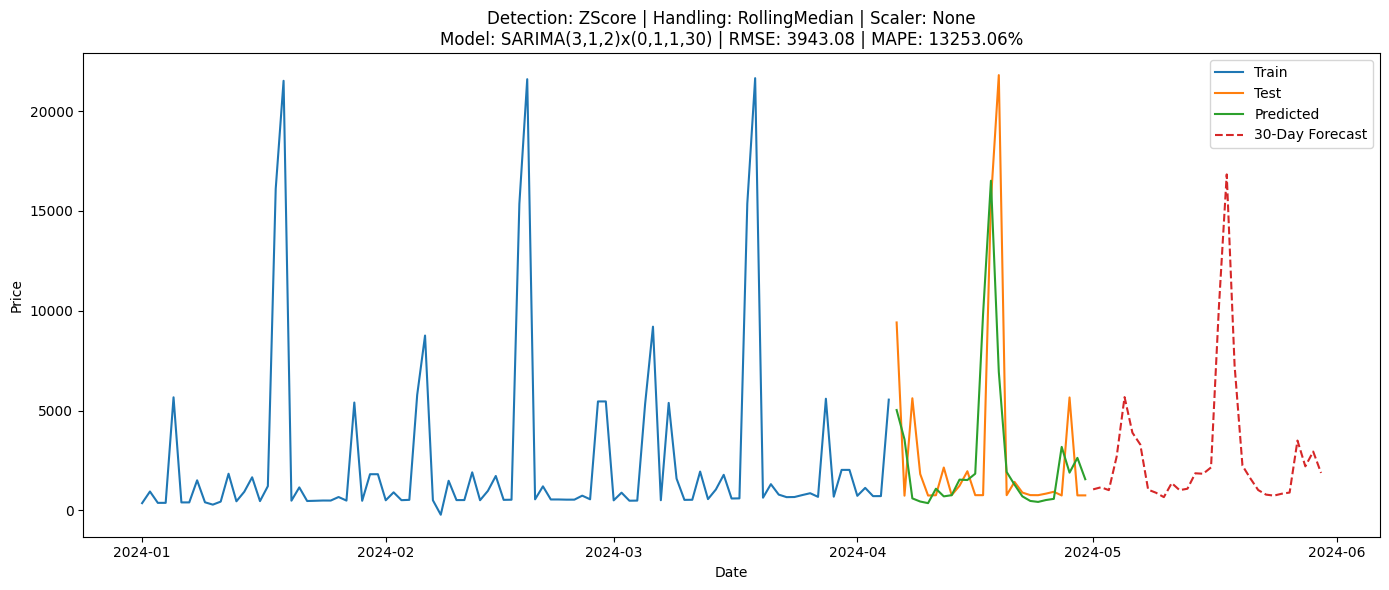

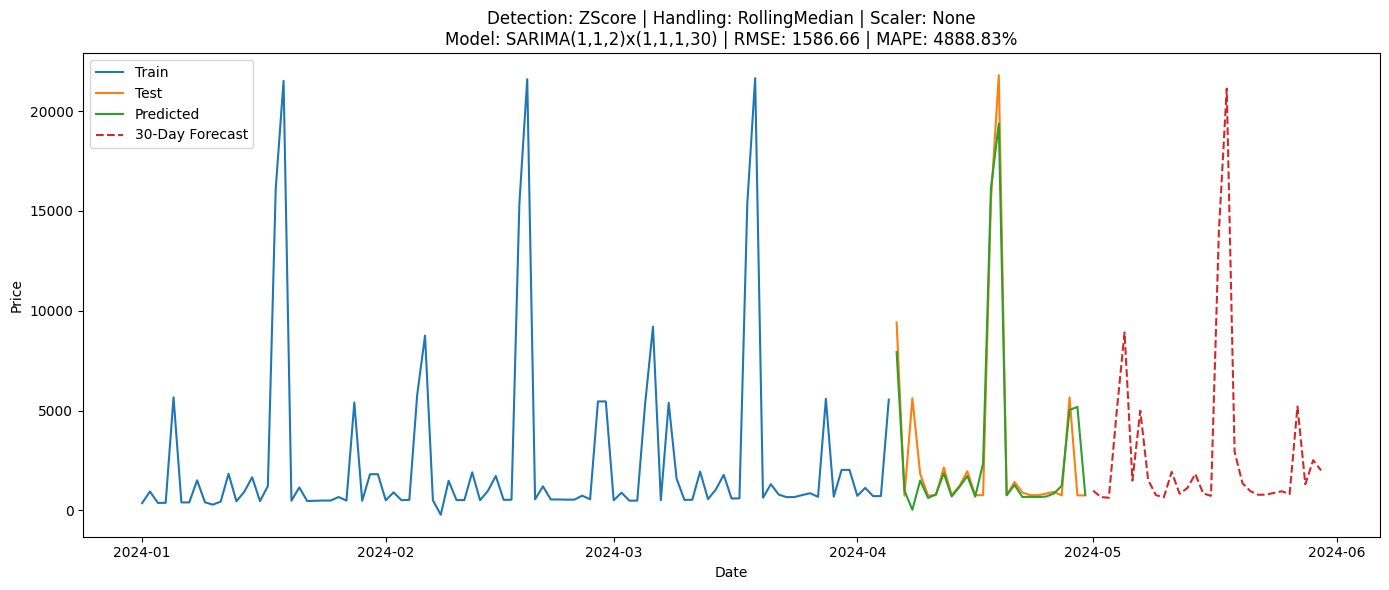

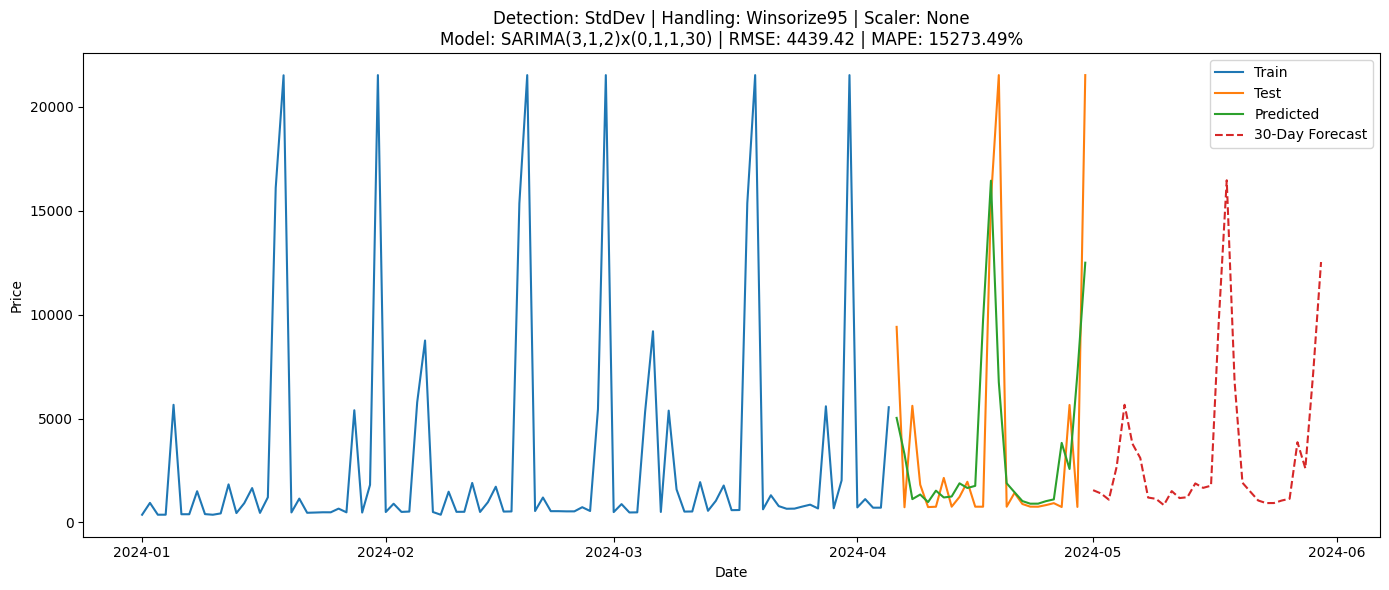

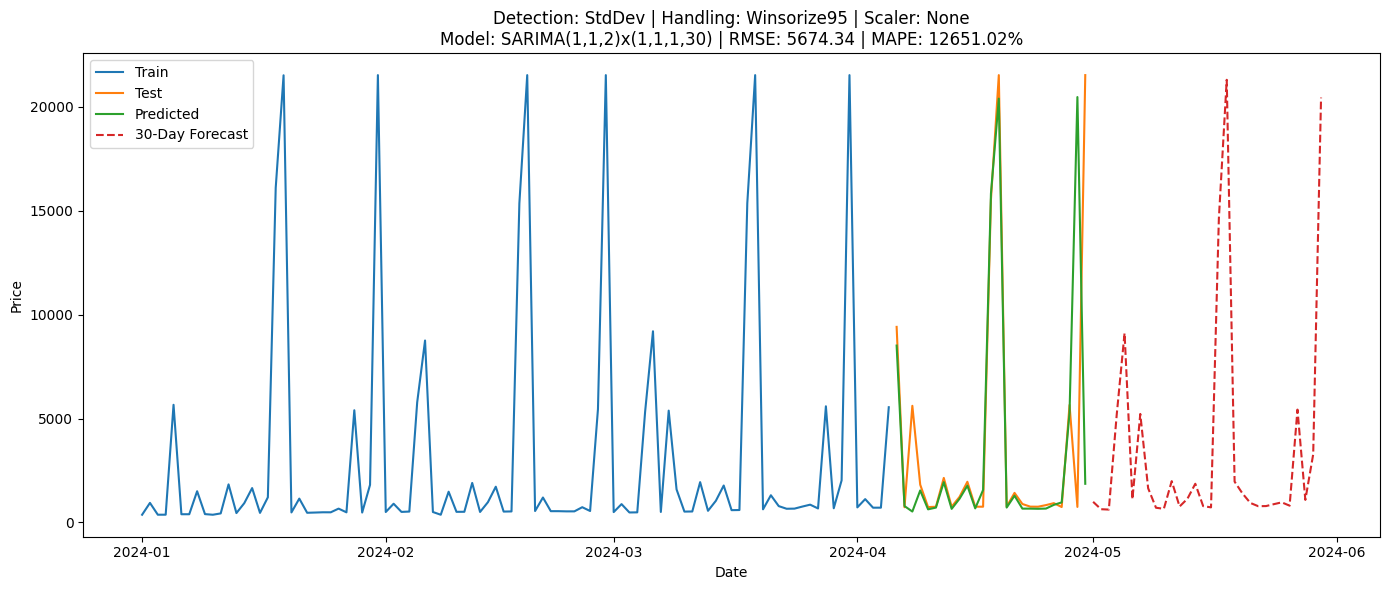

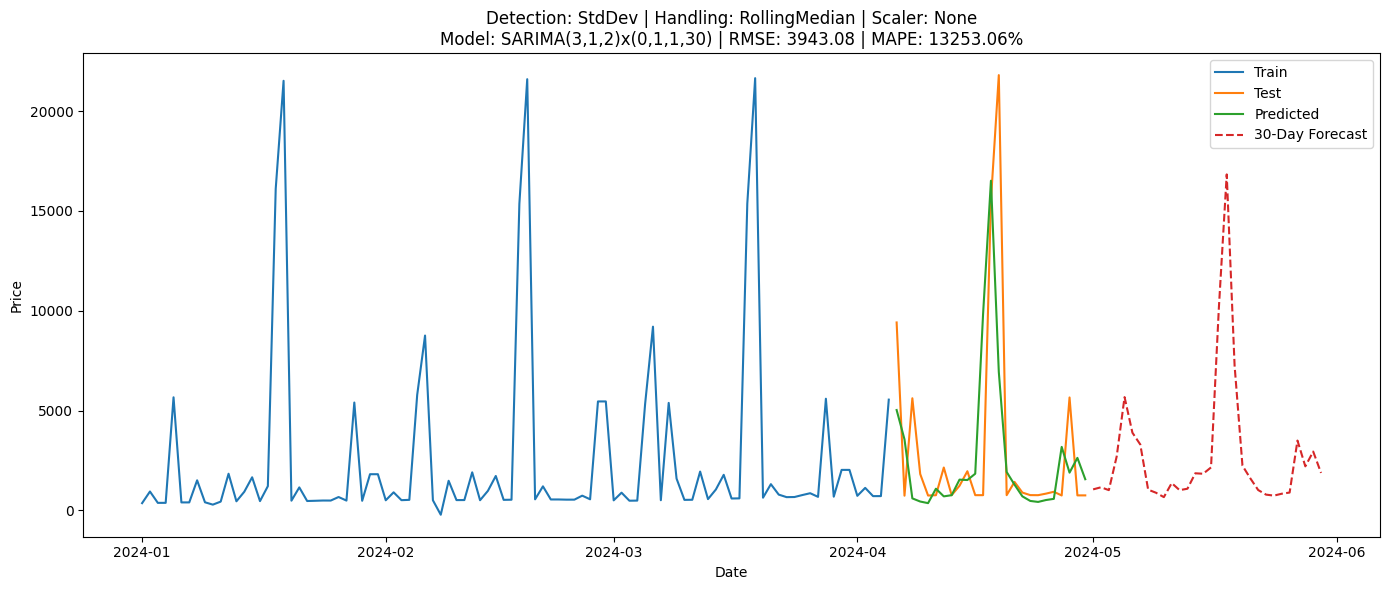

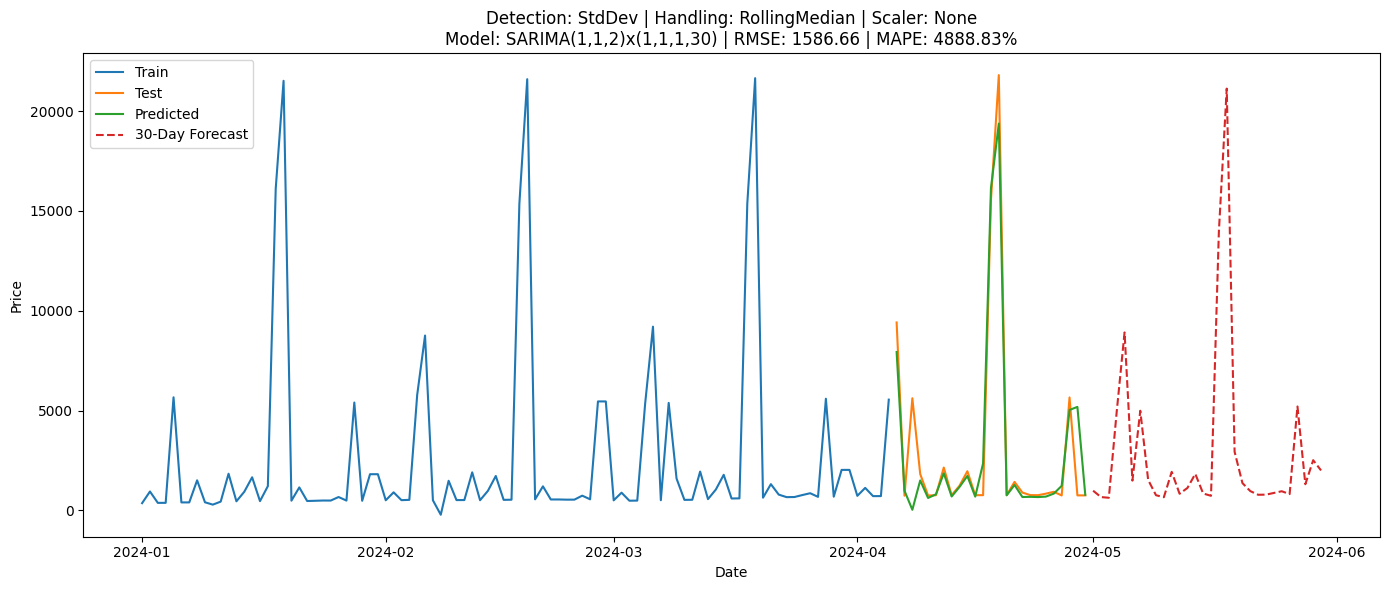


============= Final Results Summary =============
Detection      Handling                    Model    RMSE     MAPE
   ZScore RollingMedian SARIMA(1,1,2)x(1,1,1,30) 1586.66  4888.83
   StdDev RollingMedian SARIMA(1,1,2)x(1,1,1,30) 1586.66  4888.83
   StdDev RollingMedian SARIMA(3,1,2)x(0,1,1,30) 3943.08 13253.06
   ZScore RollingMedian SARIMA(3,1,2)x(0,1,1,30) 3943.08 13253.06
   StdDev   Winsorize95 SARIMA(3,1,2)x(0,1,1,30) 4439.42 15273.49
   ZScore   Winsorize95 SARIMA(3,1,2)x(0,1,1,30) 4439.42 15273.49
   ZScore   Winsorize95 SARIMA(1,1,2)x(1,1,1,30) 5674.34 12651.02
   StdDev   Winsorize95 SARIMA(1,1,2)x(1,1,1,30) 5674.34 12651.02


In [5]:
# ---------- Outlier Detection Methods ----------
def detect_outliers_zscore(series, threshold=3):
    zscores = (series - series.mean()) / series.std()
    return abs(zscores) > threshold

def detect_outliers_std(series, threshold=3):
    mean = series.mean()
    std = series.std()
    return abs(series - mean) > threshold * std

# ---------- Outlier Handling Methods ----------
def handle_outliers_winsorize(series, outliers):
    lower = np.percentile(series[~outliers], 2.5)
    upper = np.percentile(series[~outliers], 97.5)
    return np.clip(series, lower, upper)

def handle_outliers_rolling_median(series, outliers, window=3):
    rolling_median = series.rolling(window=window, center=True).median()
    series_corrected = series.copy()
    series_corrected[outliers] = rolling_median[outliers]
    return series_corrected.fillna(method='bfill').fillna(method='ffill')

# ---------- Model Configurations ----------
model_configs = {
    "SARIMA(3,1,2)x(0,1,1,30)": (SARIMAX, (3, 1, 2), (0, 1, 1, 30)),
    "SARIMA(1,1,2)x(1,1,1,30)": (SARIMAX, (1, 1, 2), (1, 1, 1, 30))
}

# ---------- Pipeline Execution ----------
detection_methods = {
    "ZScore": detect_outliers_zscore,
    "StdDev": detect_outliers_std
}

handling_methods = {
    "Winsorize95": handle_outliers_winsorize,
    "RollingMedian": handle_outliers_rolling_median
}

results = []

for det_name, detect_func in detection_methods.items():
    for handle_name, handle_func in handling_methods.items():
        # Step 1: Detect and handle outliers
        raw_series = data['Price'].copy()
        outliers = detect_func(raw_series)
        cleaned = handle_func(raw_series, outliers)

        # Step 2: Train-Test Split
        train_size = int(len(cleaned) * 0.8)
        train, test = cleaned[:train_size], cleaned[train_size:]
        train_index = data.index[:train_size]
        test_index = data.index[train_size:]
        future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30)

        for model_name, (model_class, order, seasonal_order) in model_configs.items():
            try:
                model = model_class(train, order=order, seasonal_order=seasonal_order,
                                    enforce_stationarity=False, enforce_invertibility=False).fit()

                pred_test = model.forecast(steps=len(test))
                rmse = sqrt(mean_squared_error(test, pred_test))
                mape = mean_absolute_percentage_error(test, pred_test) * 100

                # Forecast next 30 days
                forecast = model.forecast(steps=len(test) + 30)[-30:]

                # Plot
                plt.figure(figsize=(14, 6))
                plt.plot(train_index, train, label='Train')
                plt.plot(test_index, test, label='Test')
                plt.plot(test_index, pred_test, label='Predicted')
                plt.plot(future_index, forecast, label='30-Day Forecast', linestyle='--')
                plt.title(f"Detection: {det_name} | Handling: {handle_name} | Scaler: None\nModel: {model_name} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
                plt.xlabel("Date")
                plt.ylabel("Price")
                plt.legend()
                plt.tight_layout()
                plt.show()

                results.append({
                    "Detection": det_name,
                    "Handling": handle_name,
                    "Model": model_name,
                    "RMSE": round(rmse, 2),
                    "MAPE": round(mape, 2)
                })

            except Exception as e:
                print(f"Model {model_name} failed for {det_name} + {handle_name}: {e}")

# ---------- Results Summary ----------
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\n============= Final Results Summary =============")
print(results_df.to_string(index=False))

# modified z-score,iqr,std, isolation forest + winsorize 1% and 99%/rolling median with 3,5,7,9

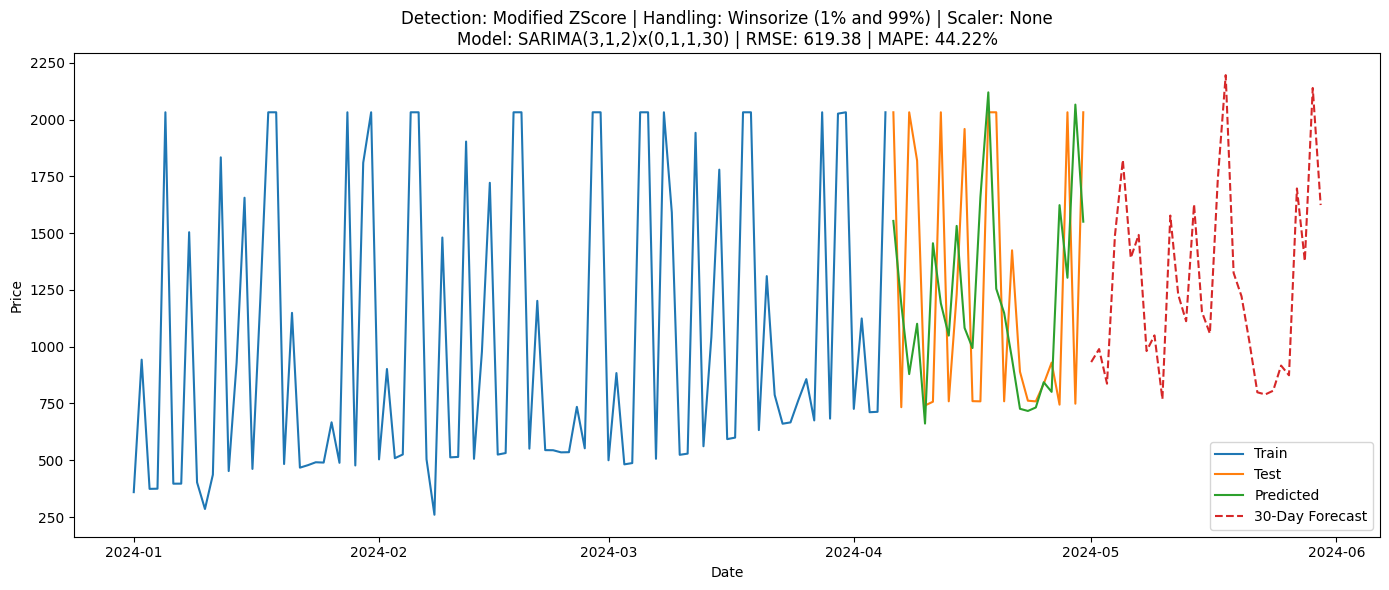

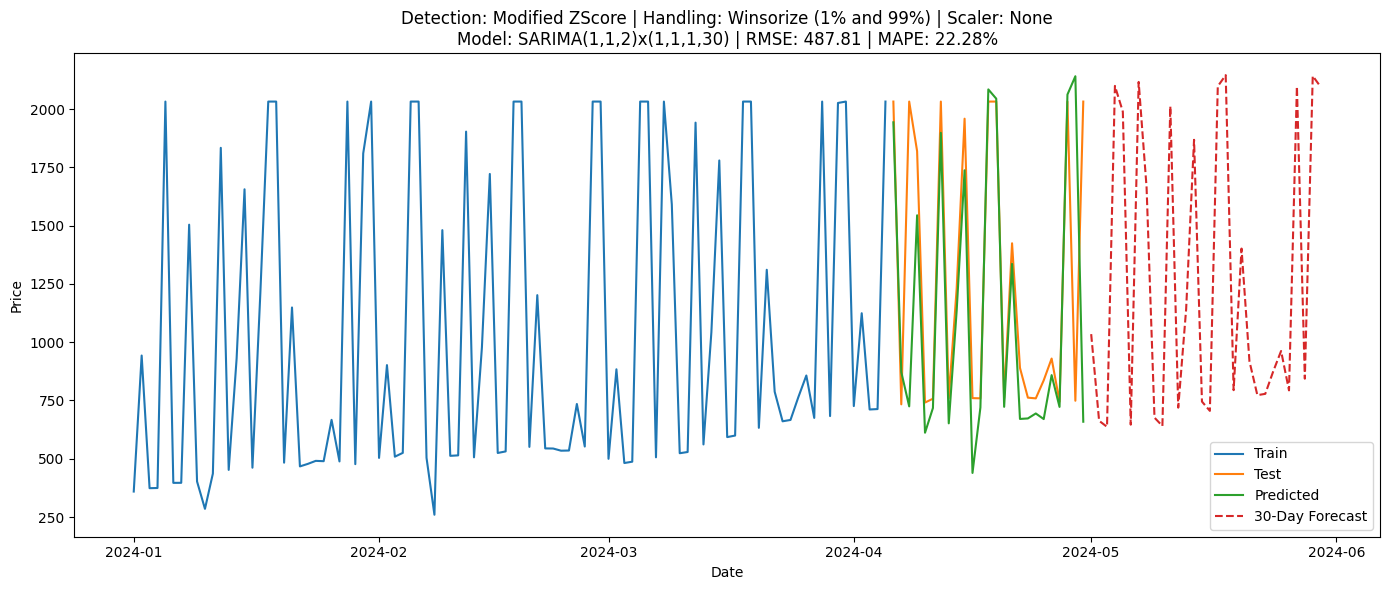

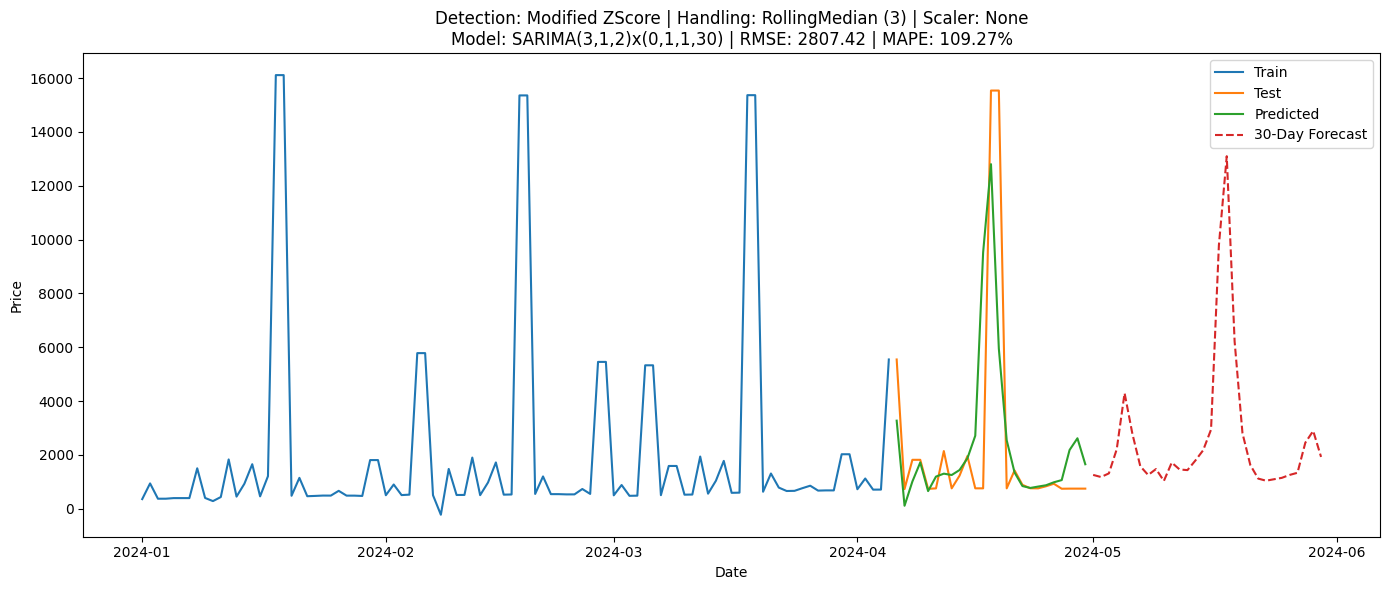

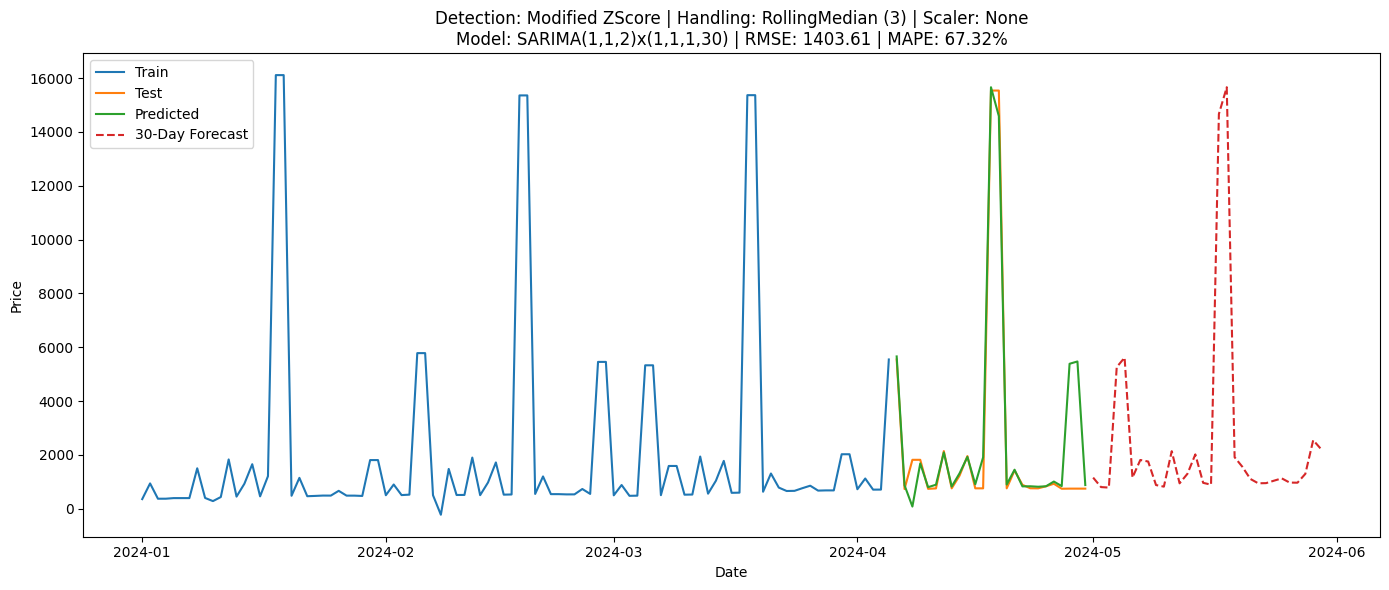

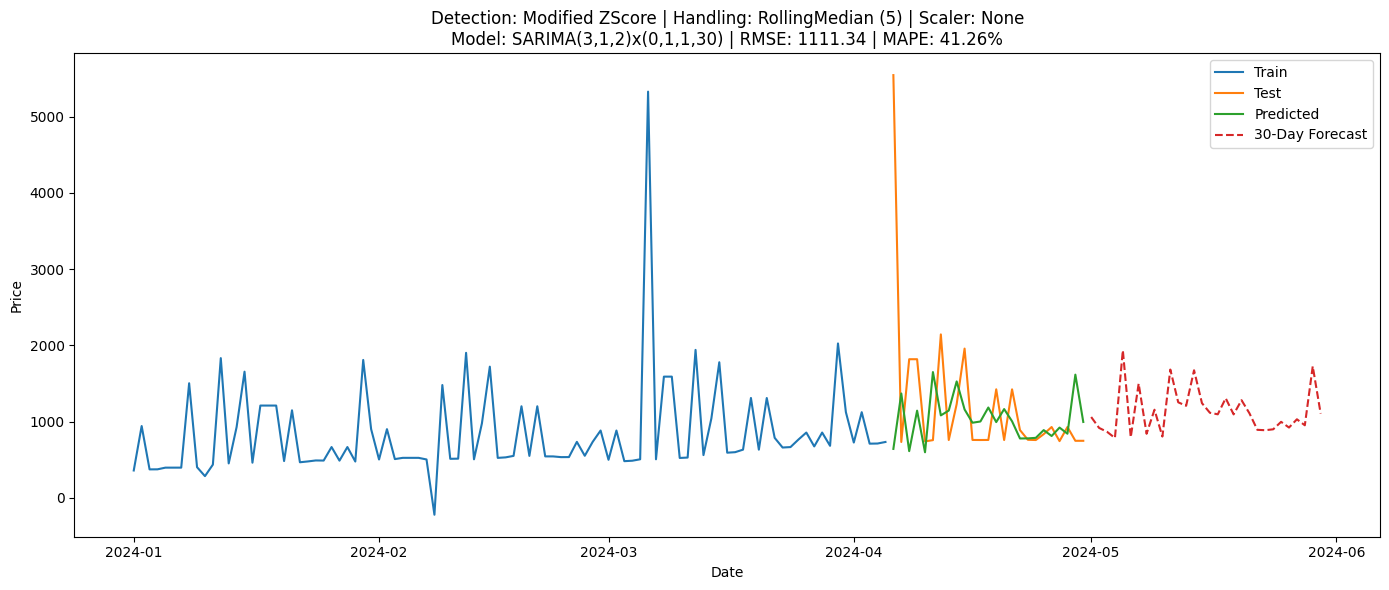

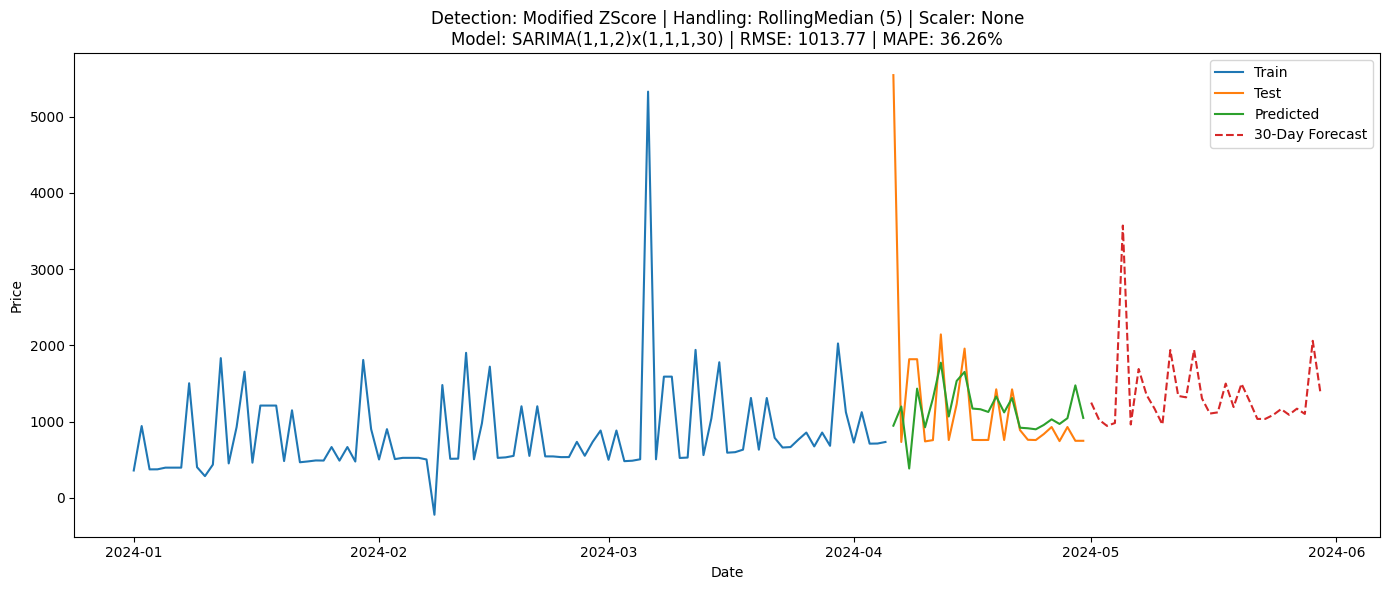

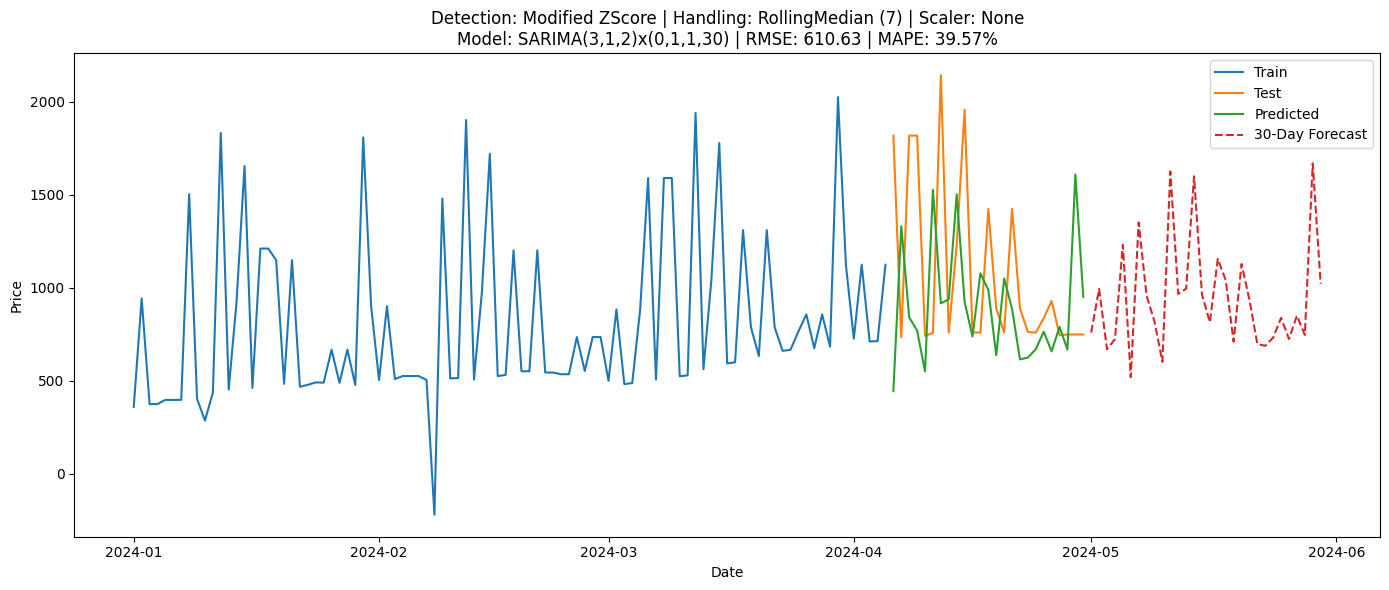

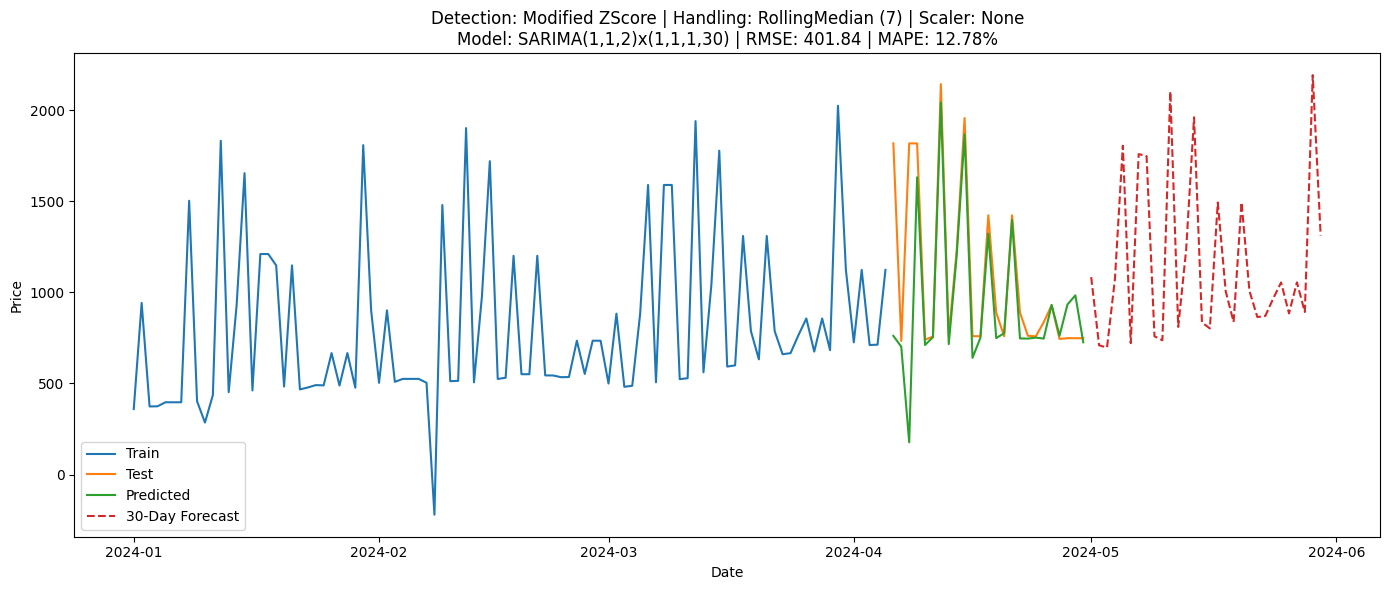

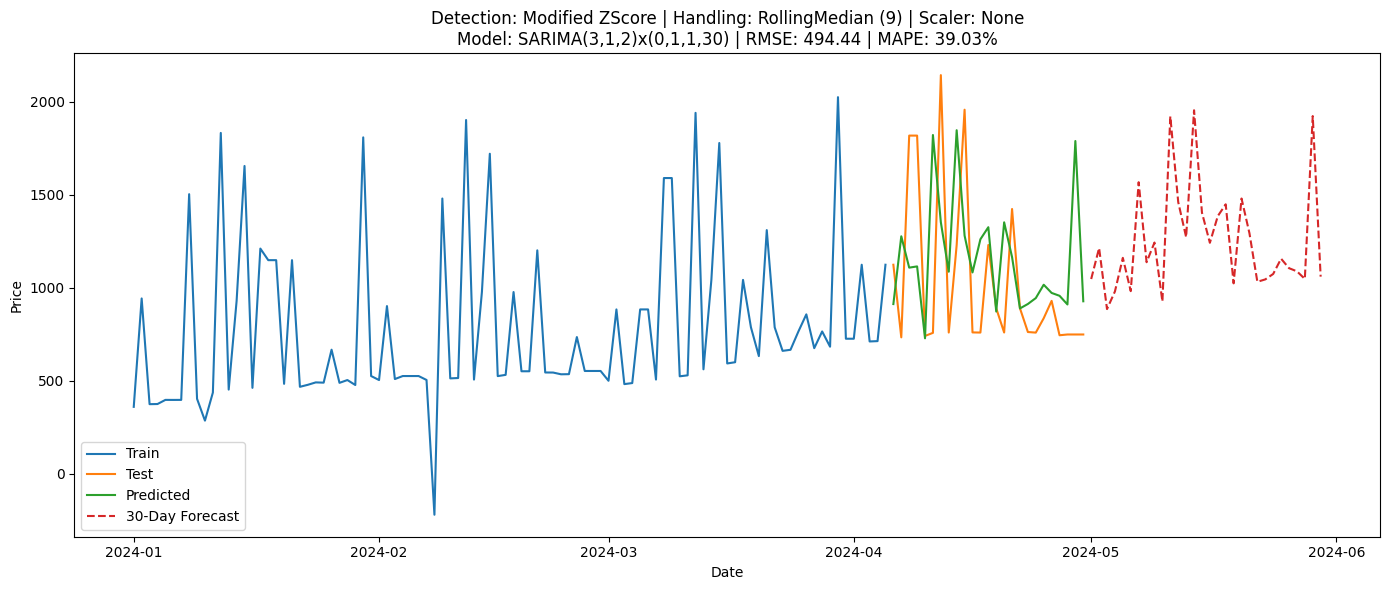

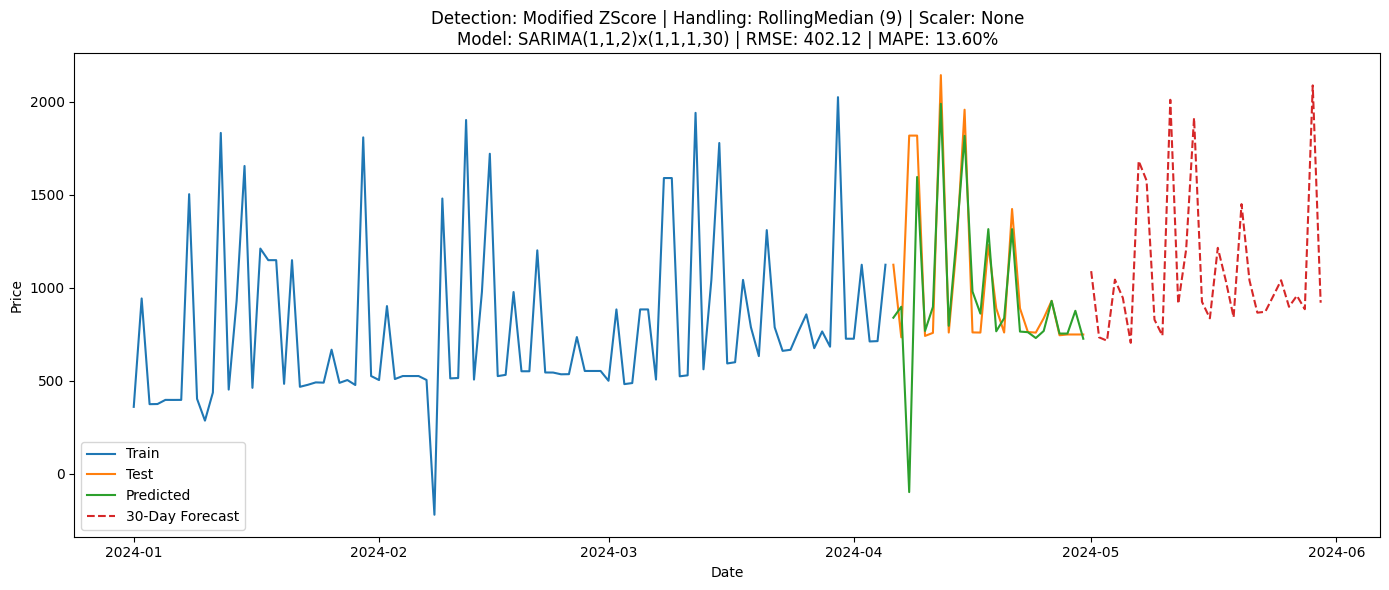

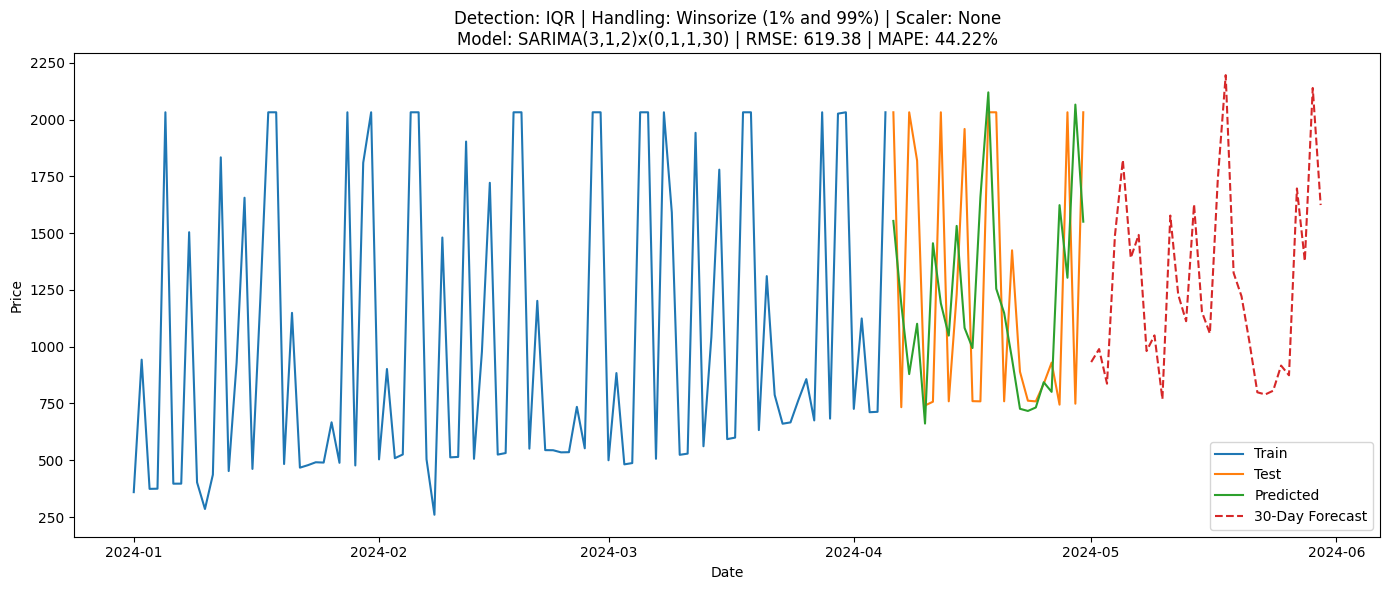

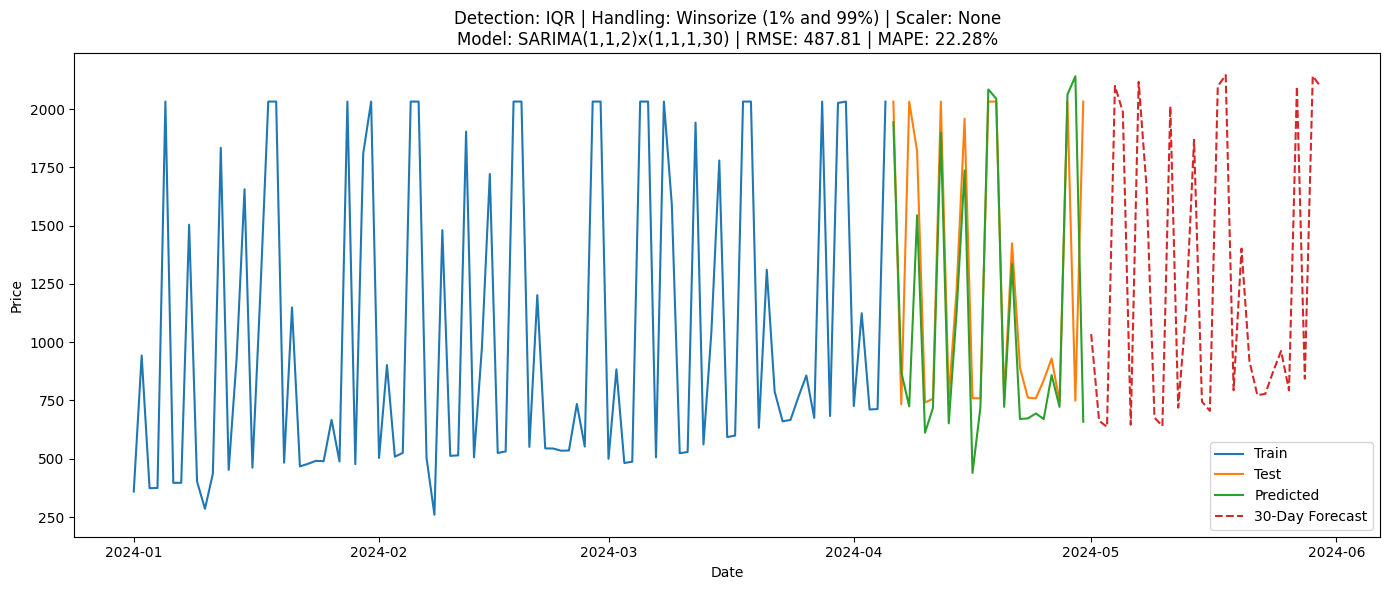

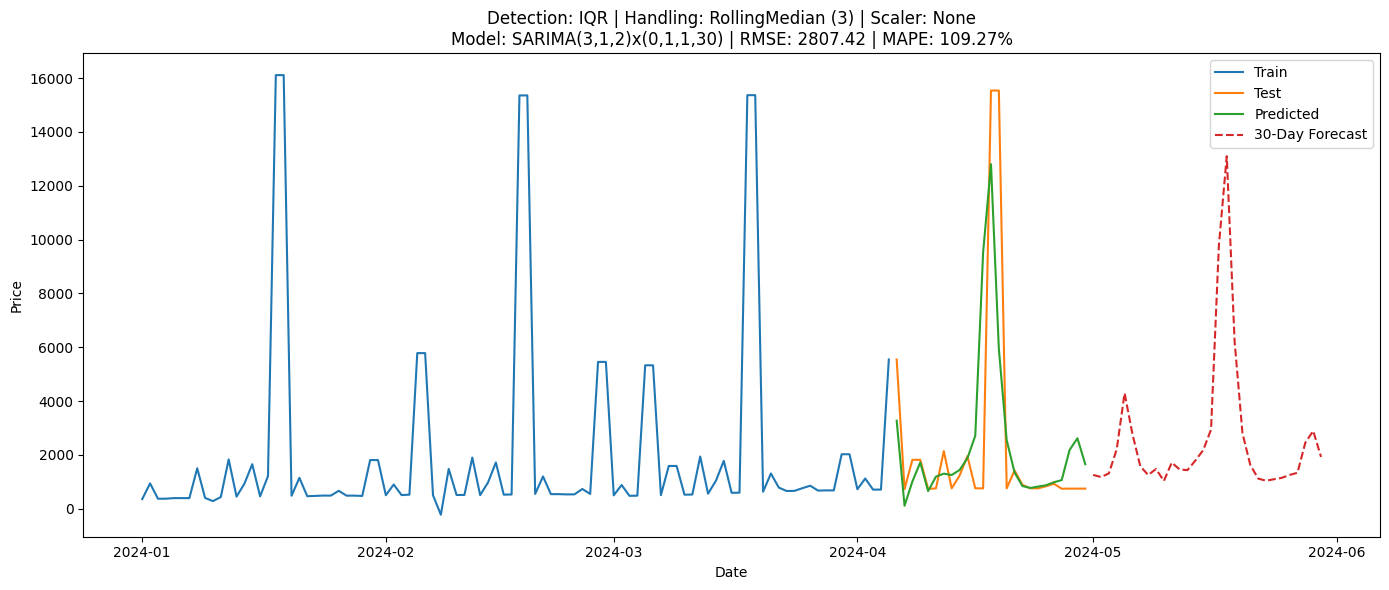

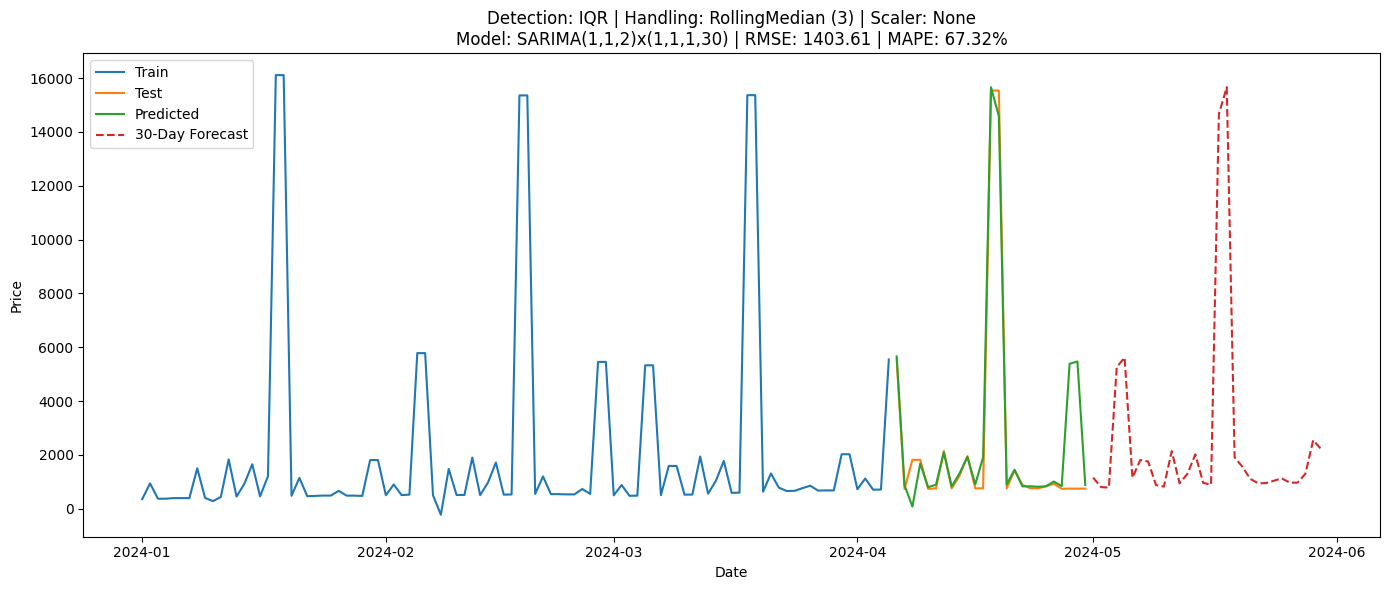

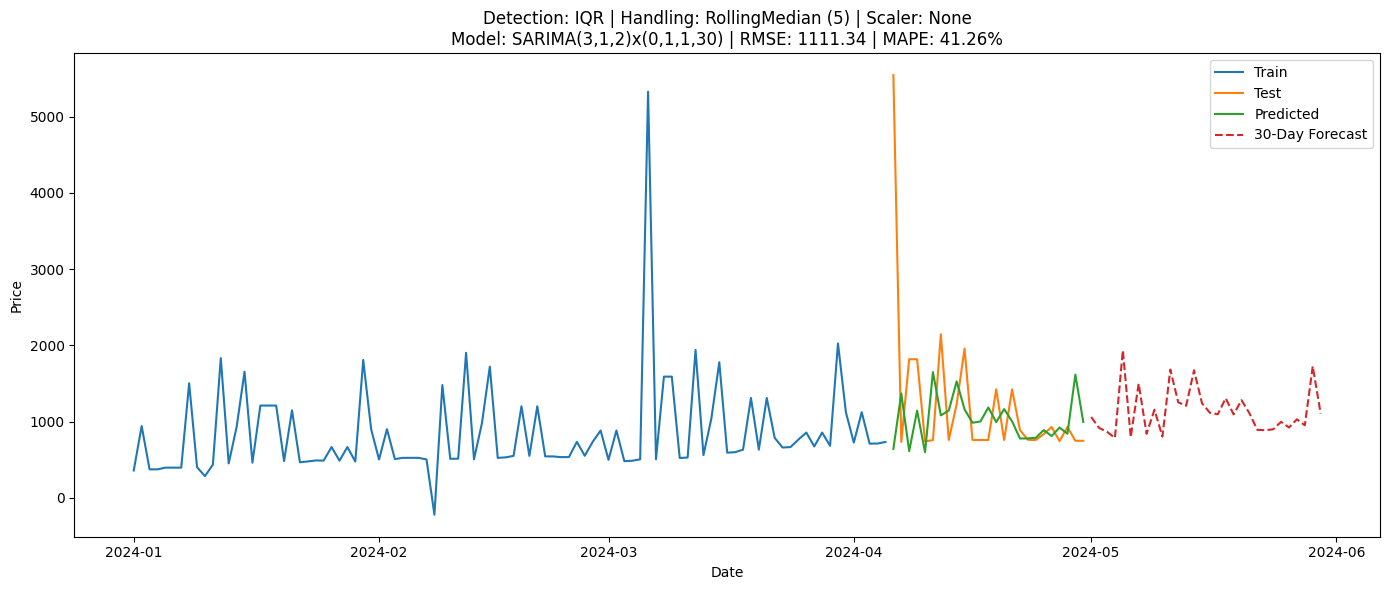

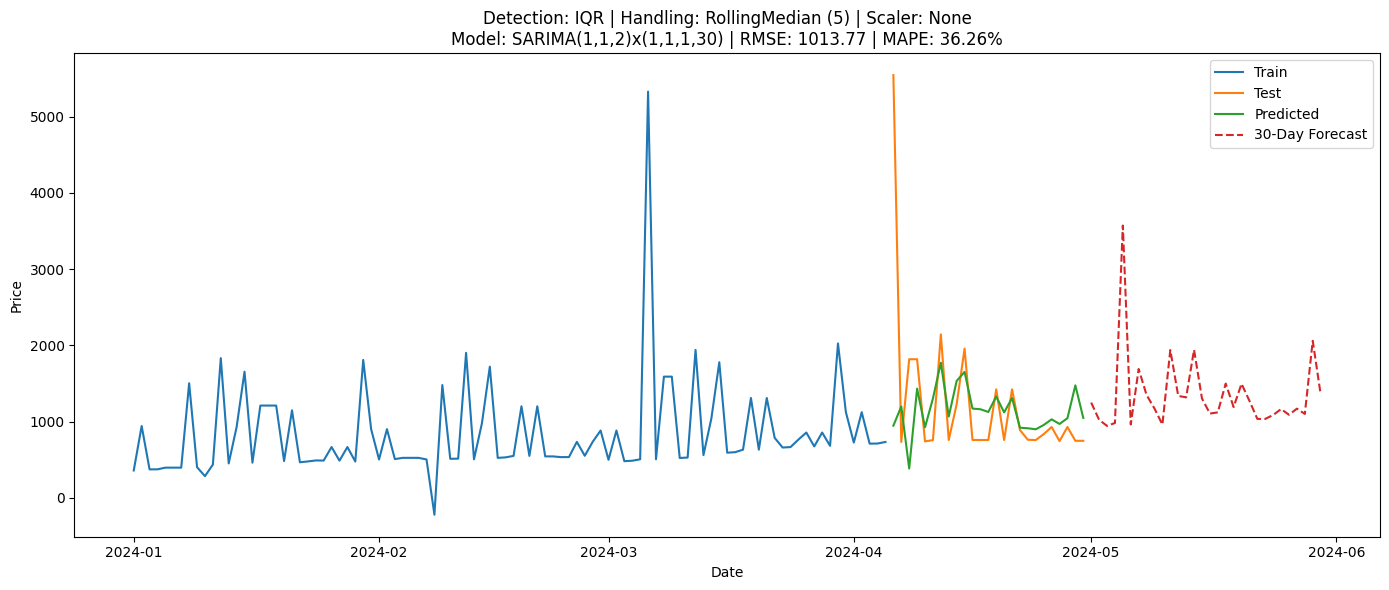

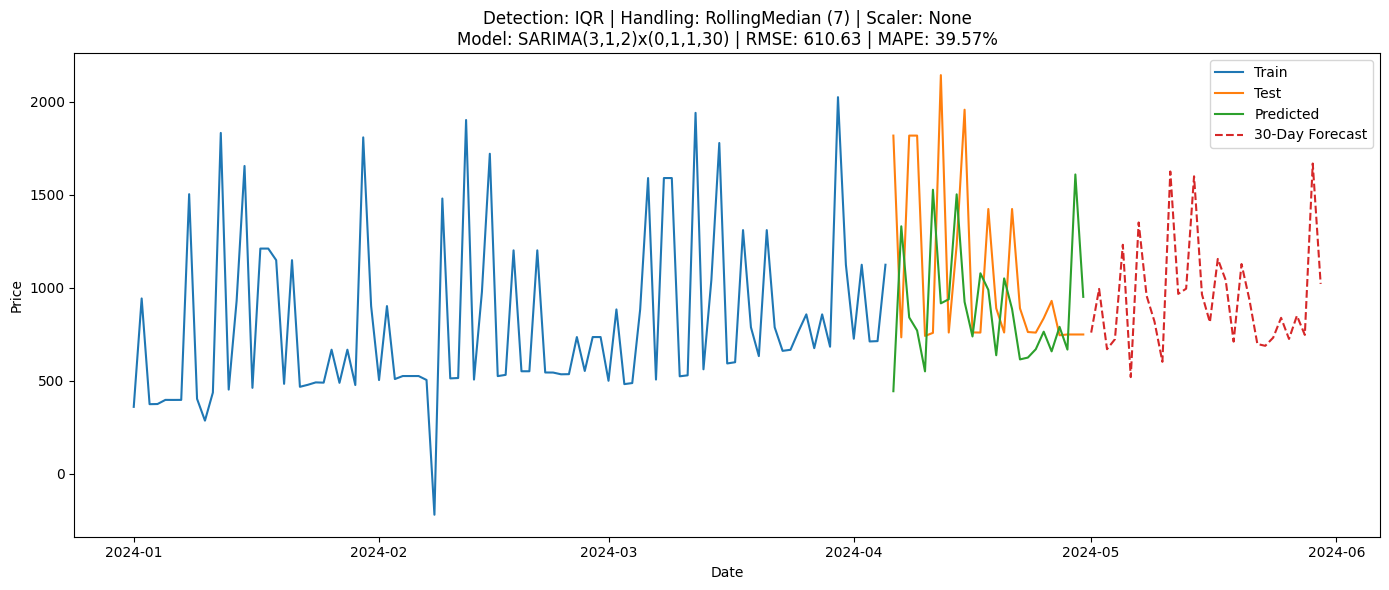

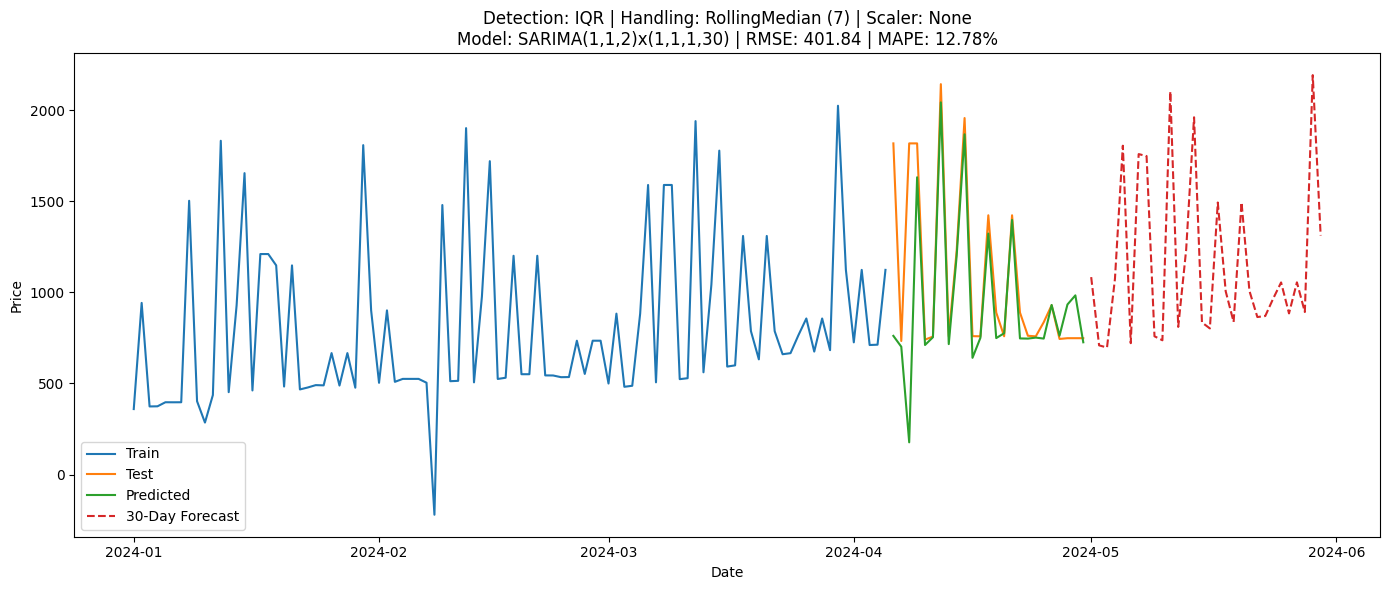

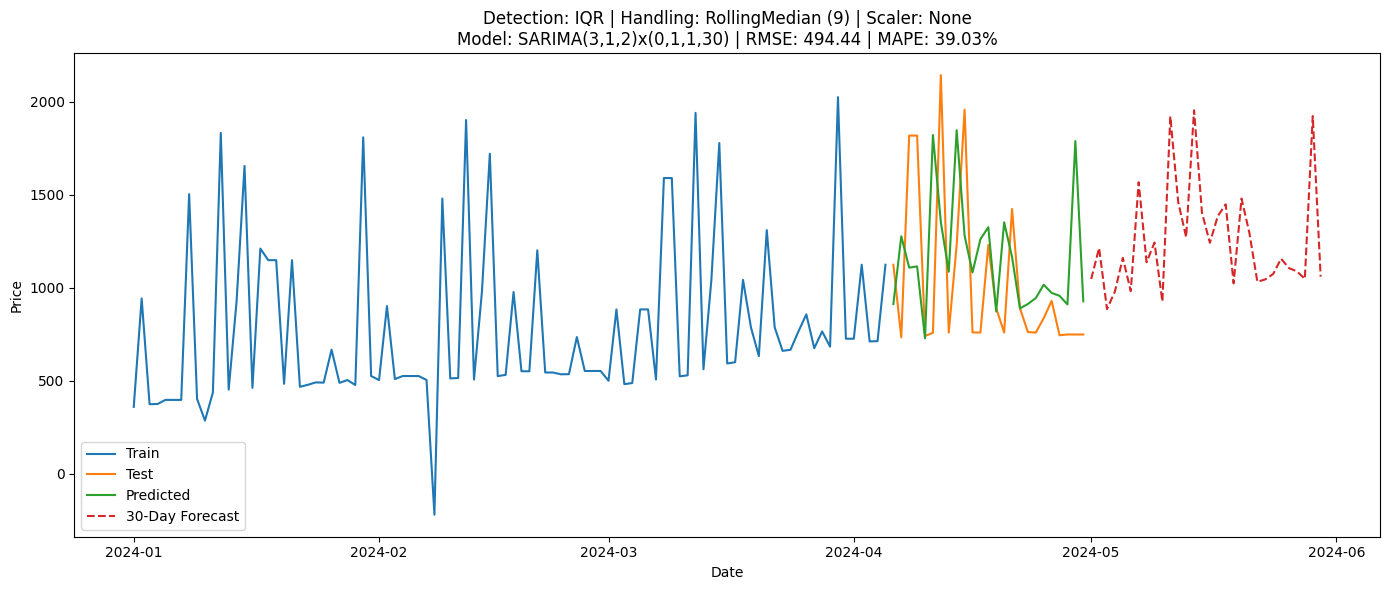

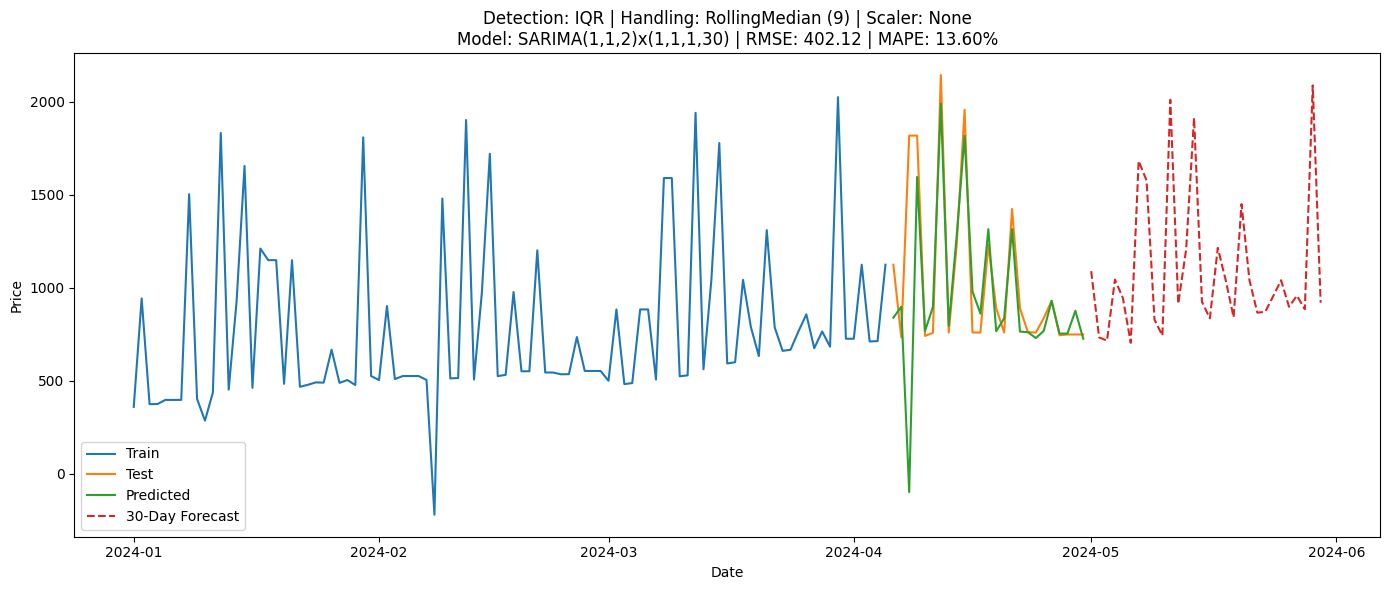

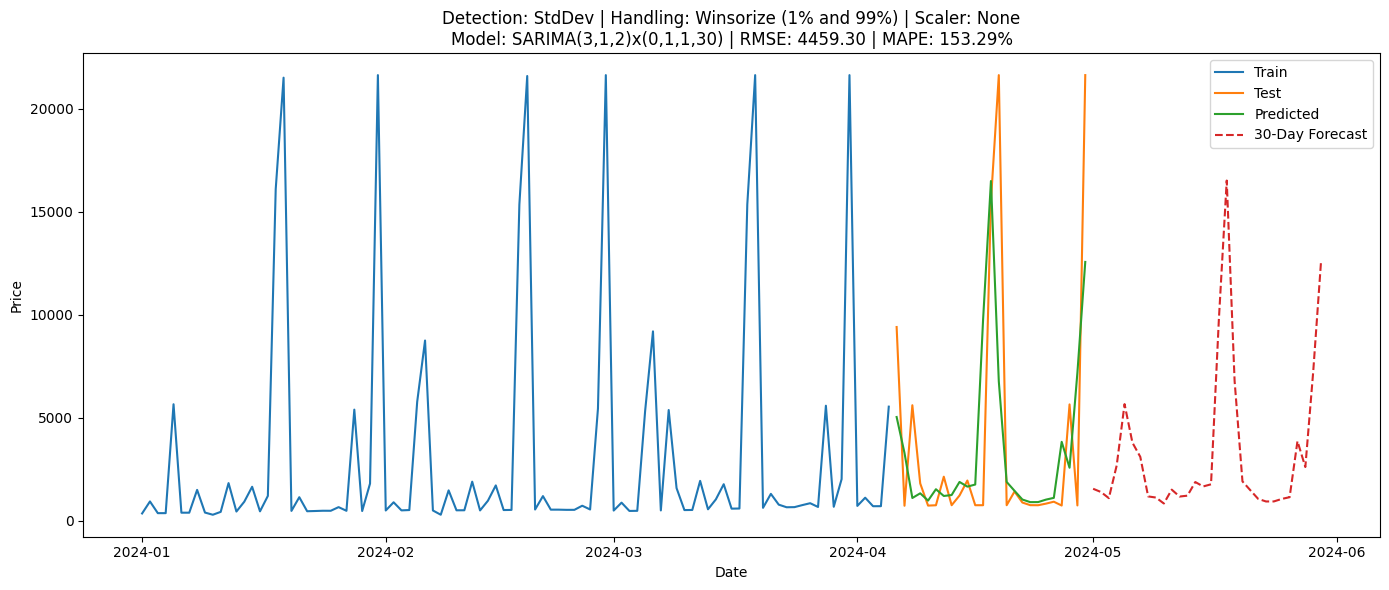

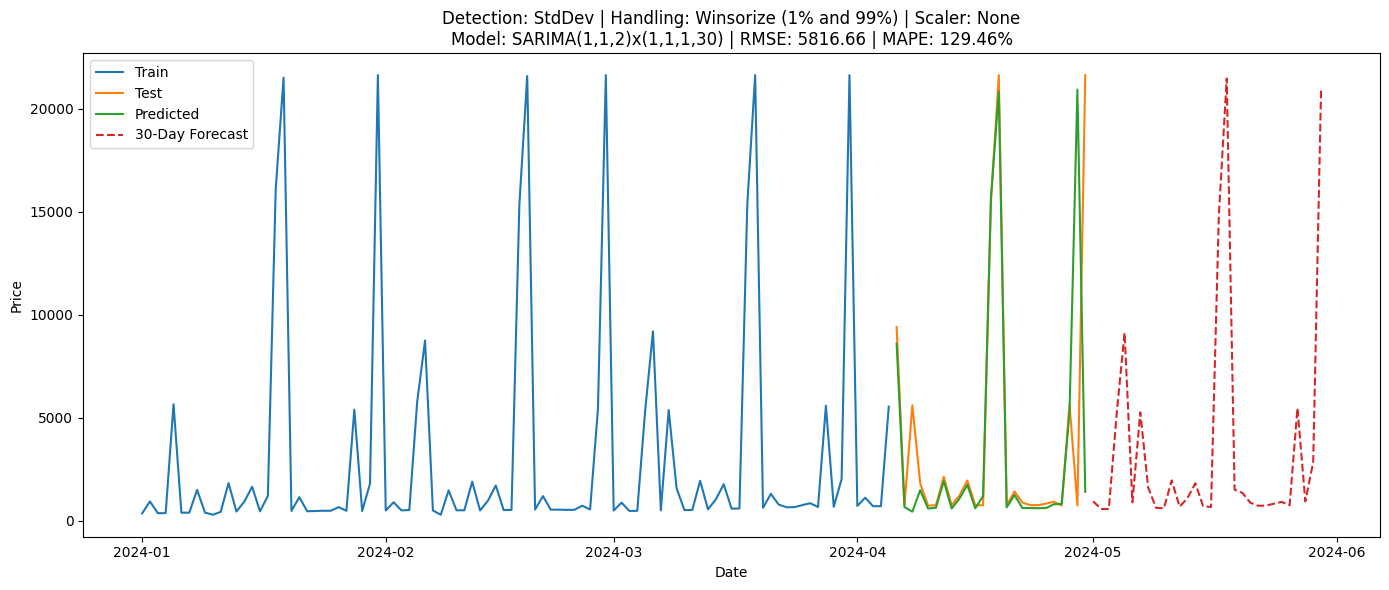

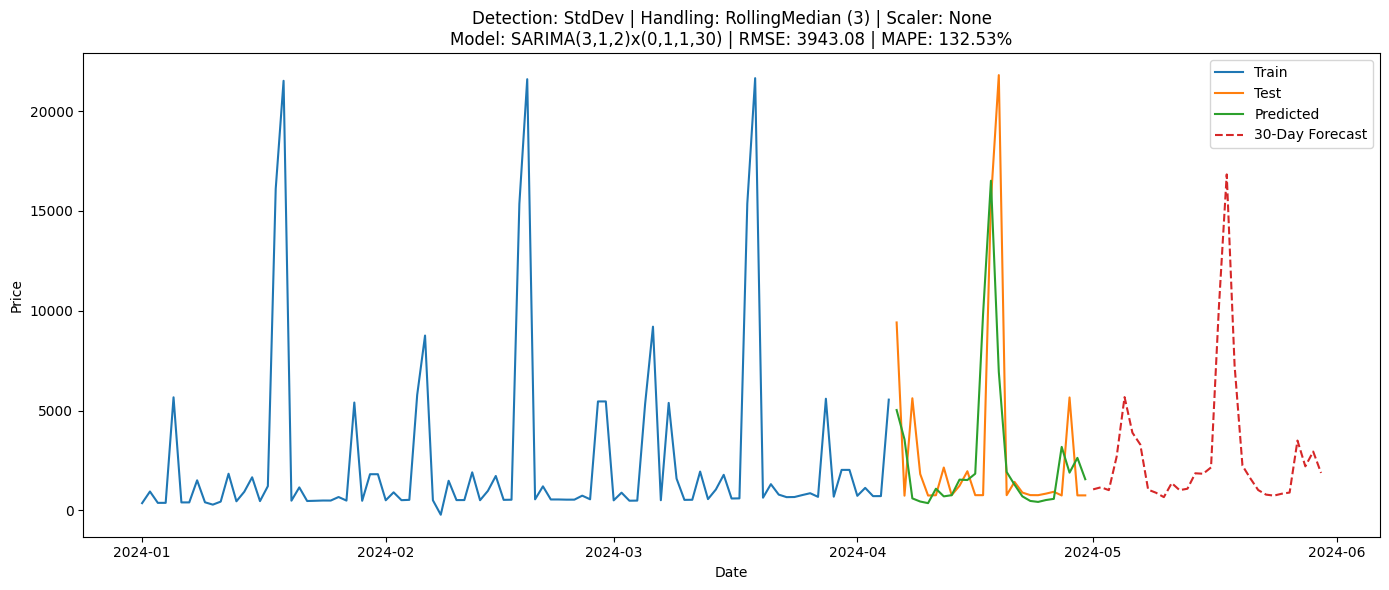

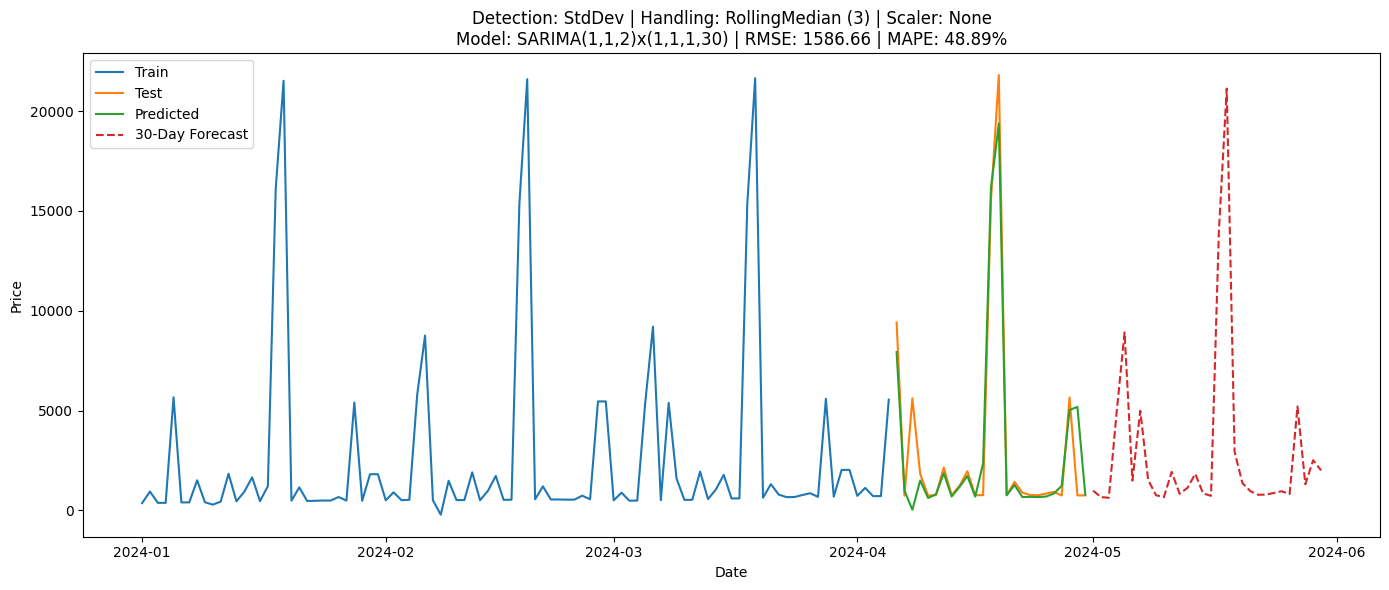

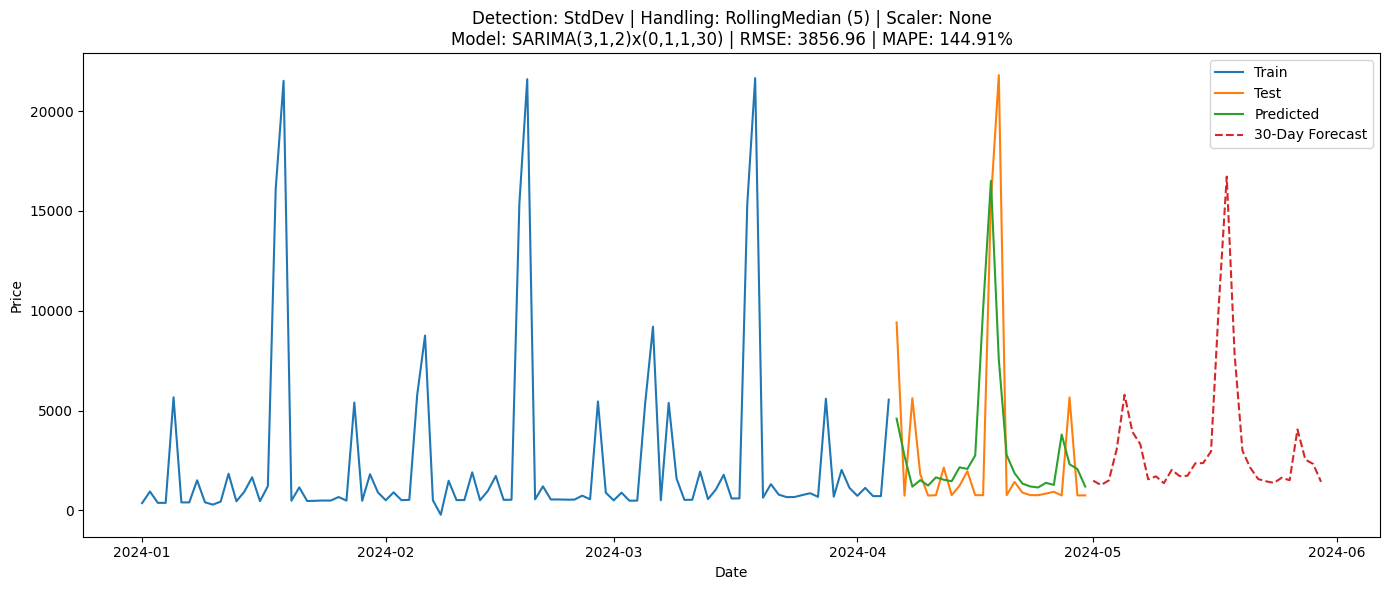

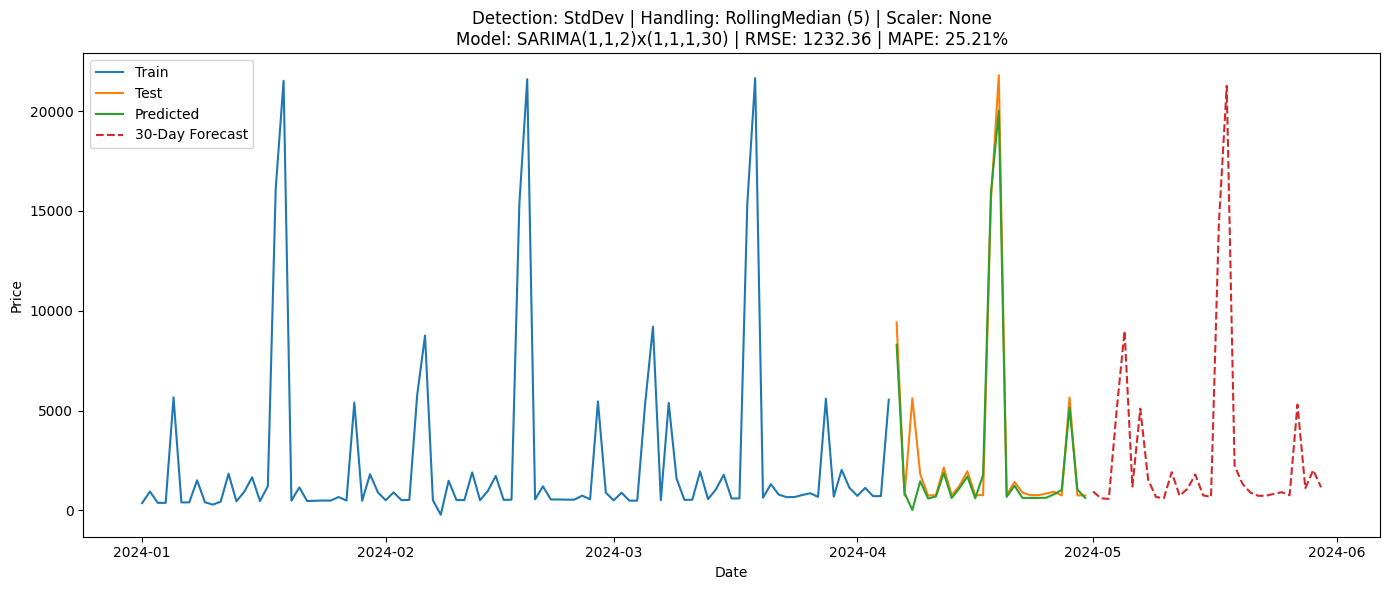

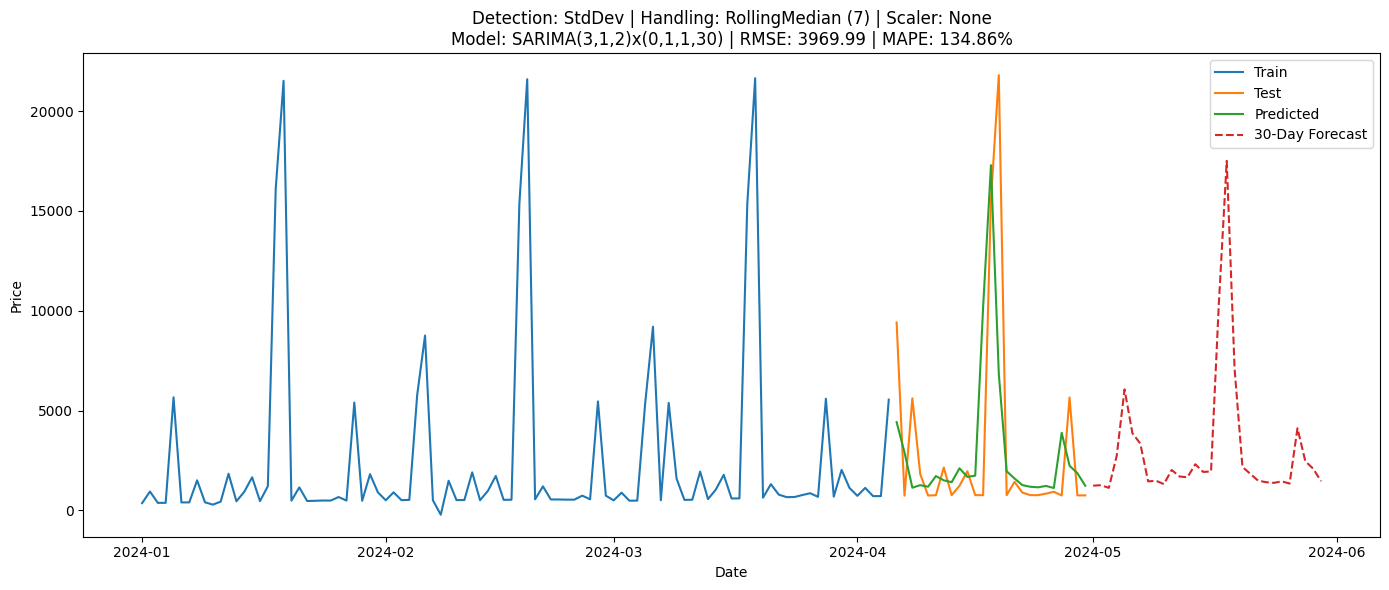

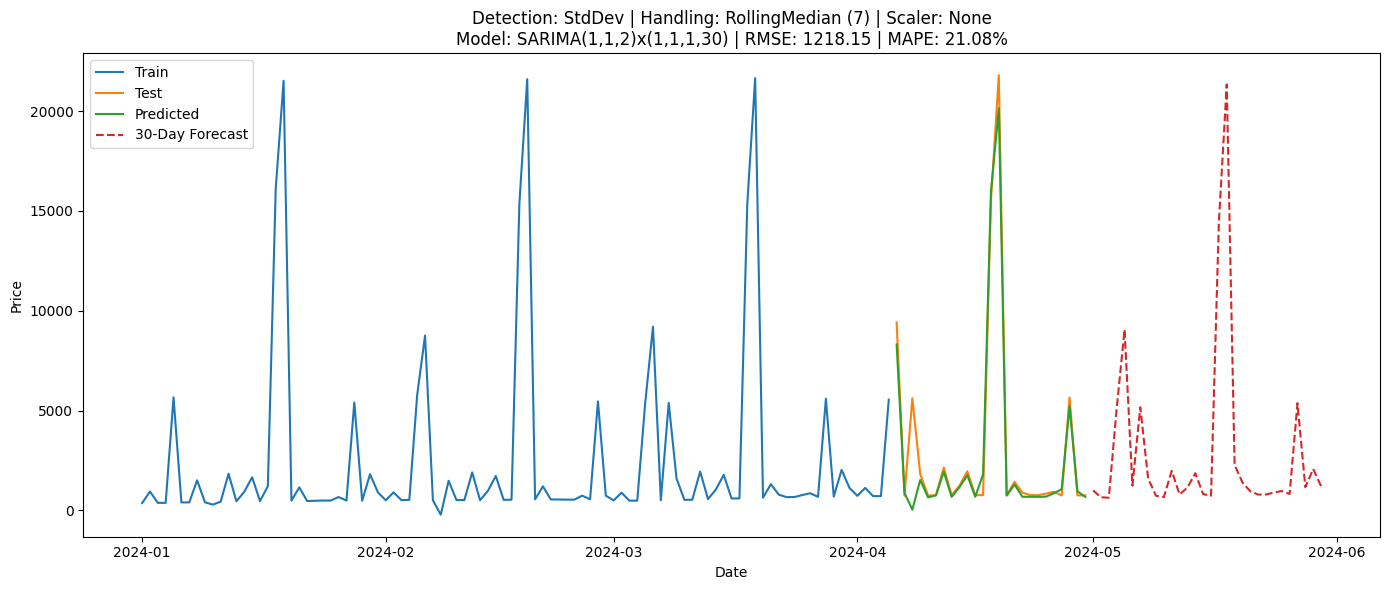

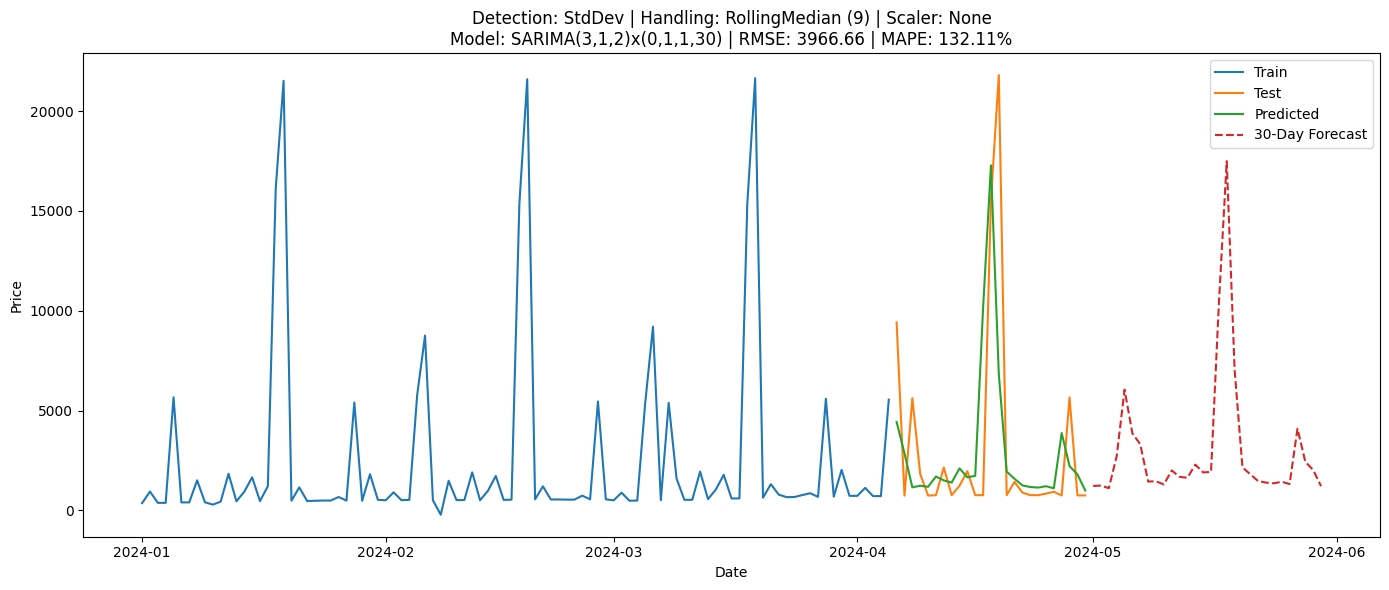

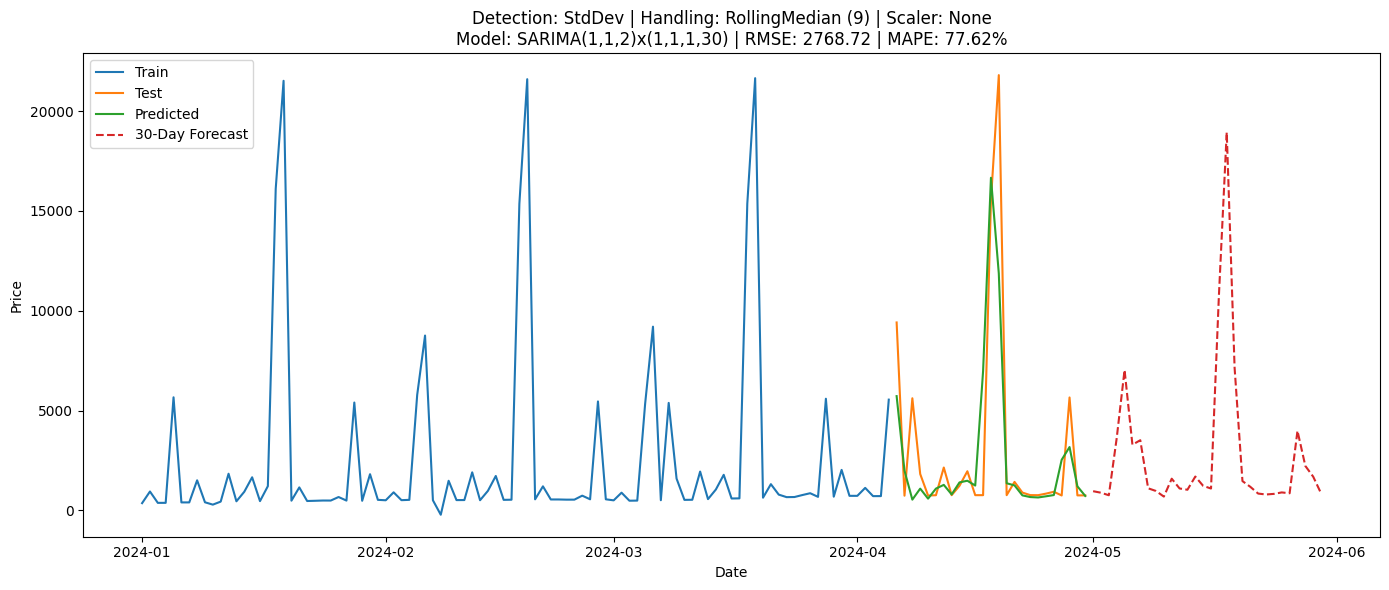

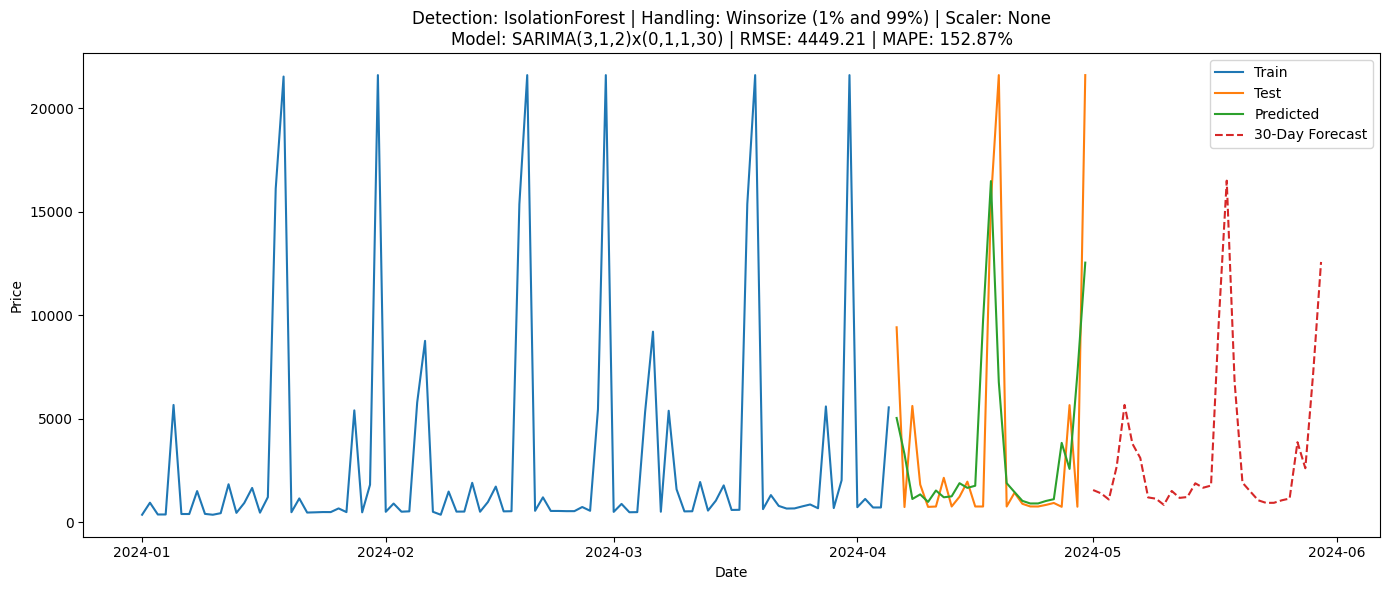

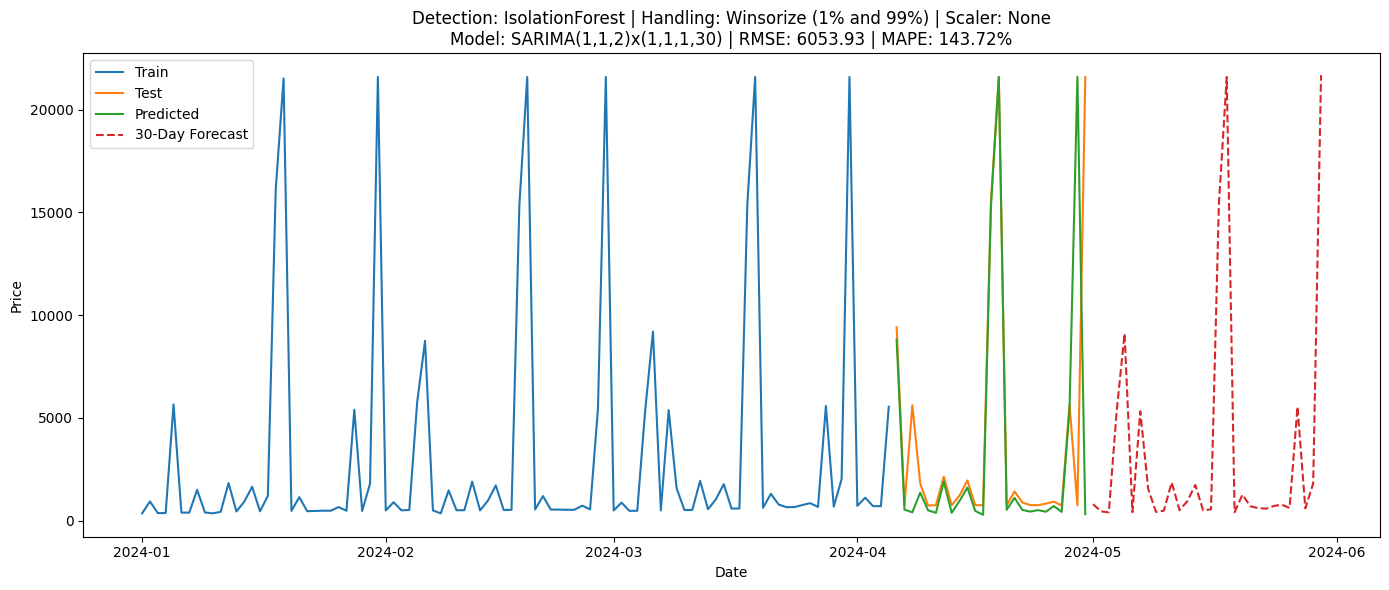

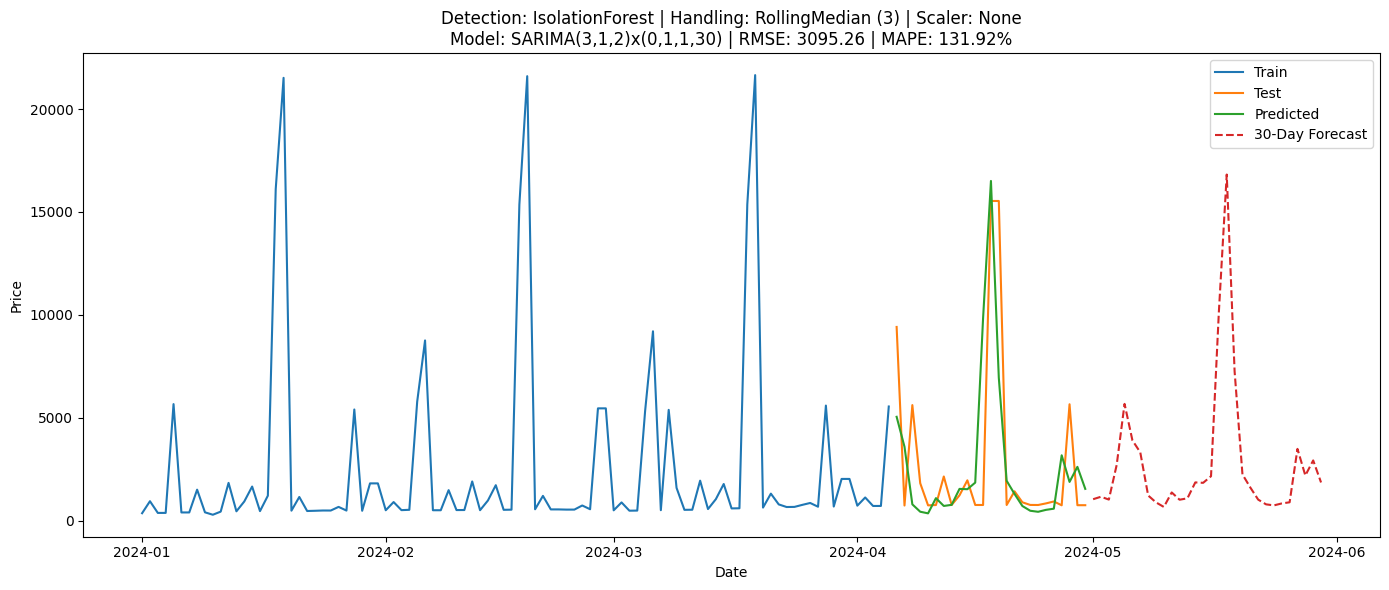

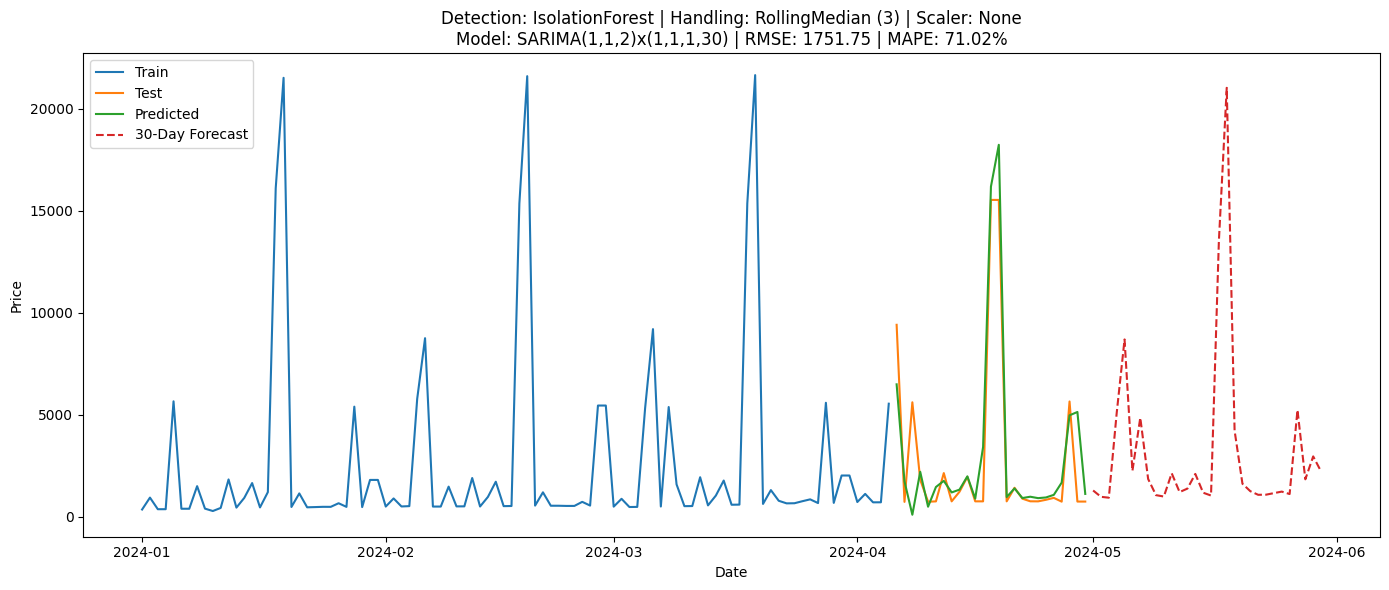

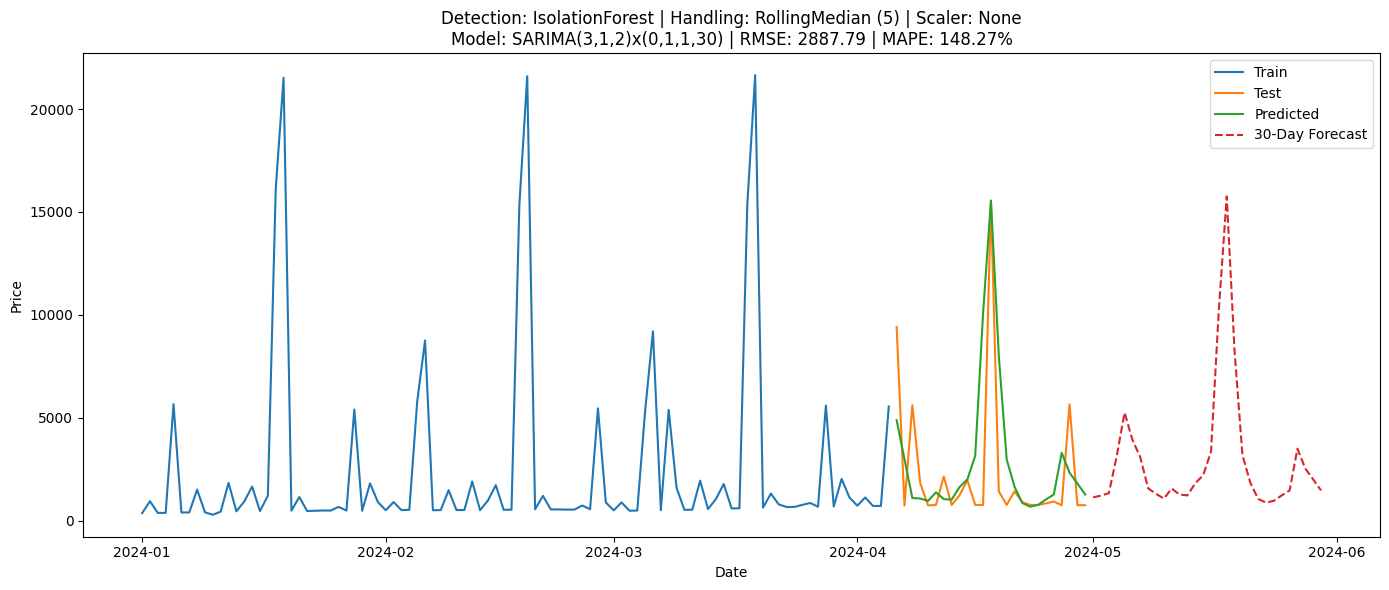

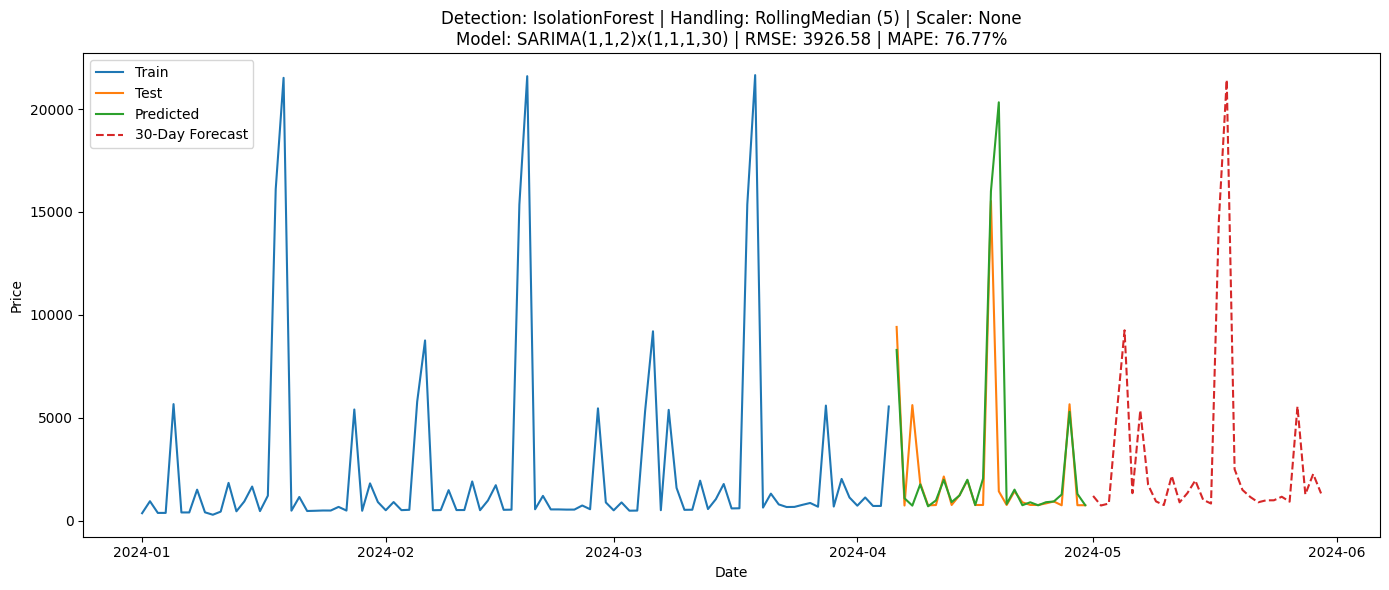

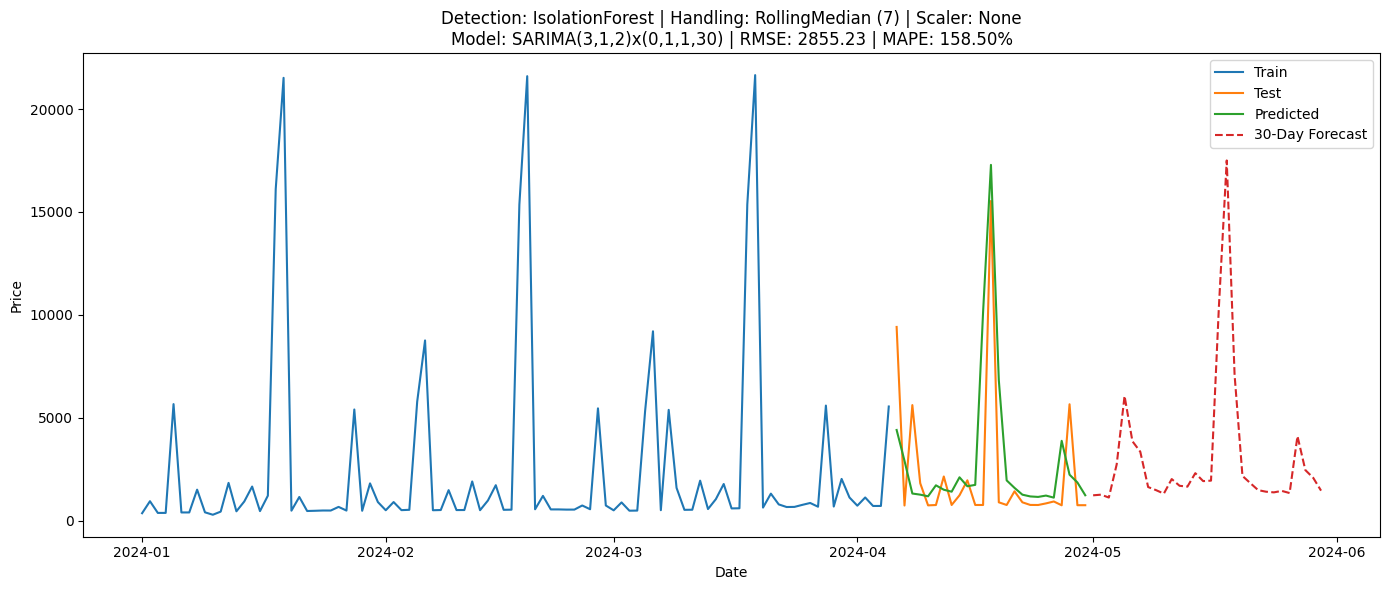

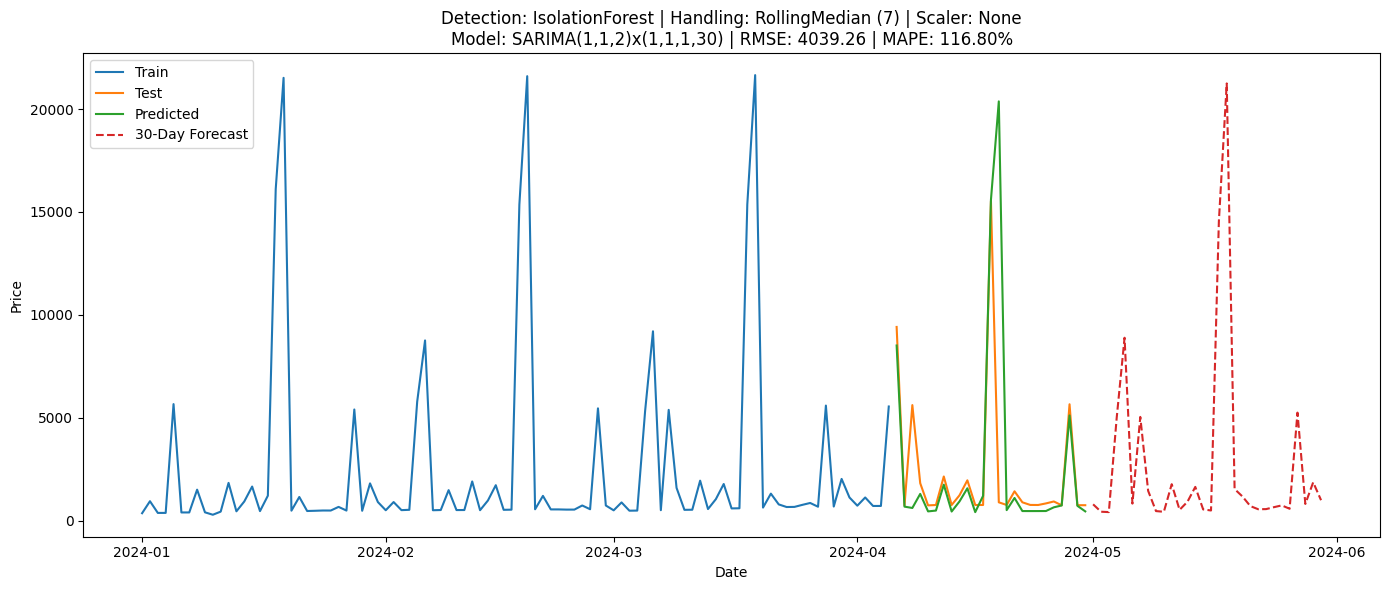

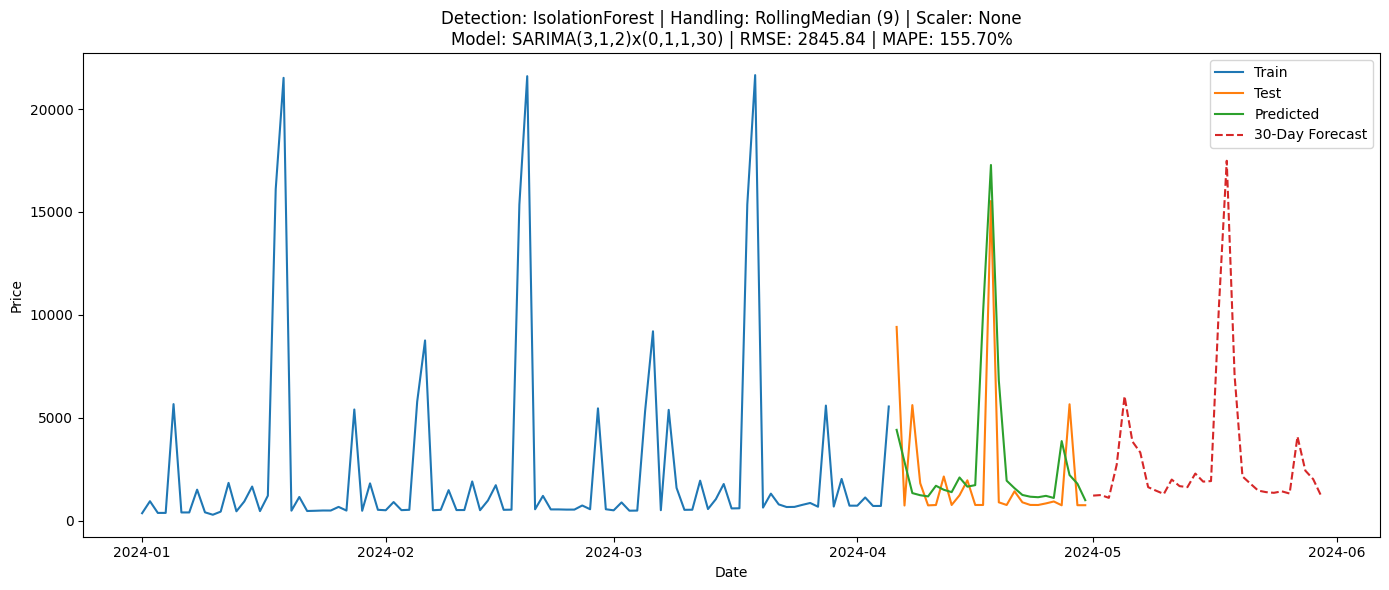

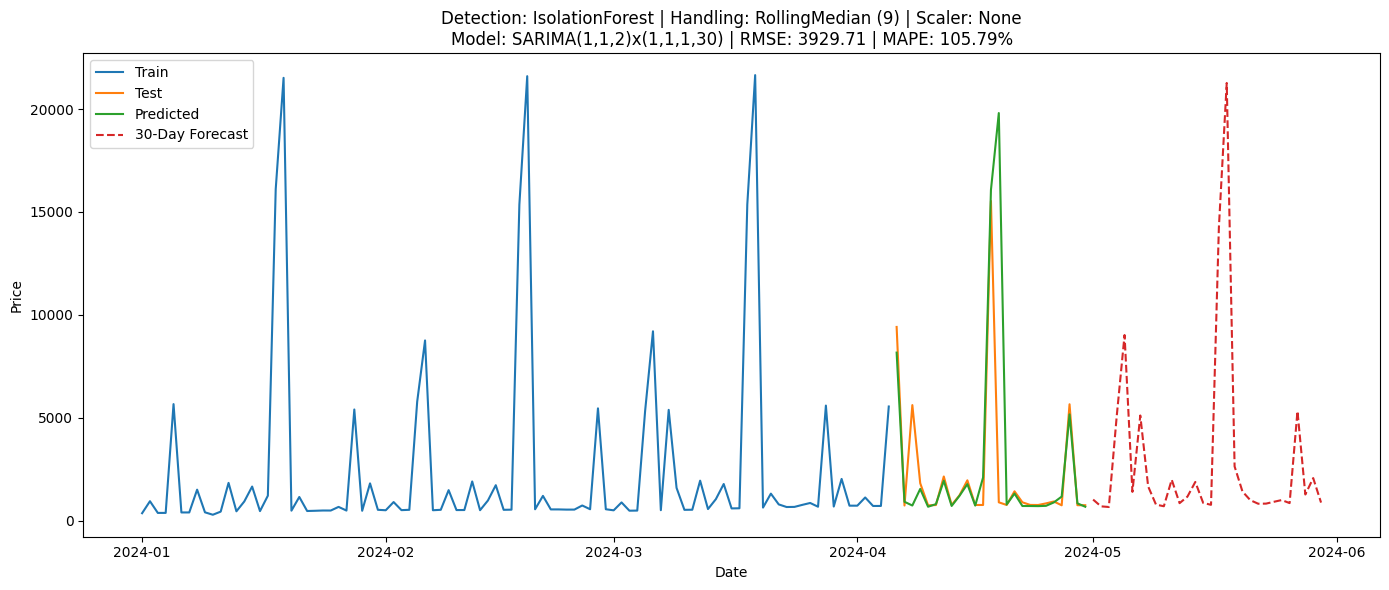


============= Final Results Summary =============
      Detection               Handling                    Model    RMSE   MAPE
Modified ZScore      RollingMedian (7) SARIMA(1,1,2)x(1,1,1,30)  401.84  12.78
            IQR      RollingMedian (7) SARIMA(1,1,2)x(1,1,1,30)  401.84  12.78
            IQR      RollingMedian (9) SARIMA(1,1,2)x(1,1,1,30)  402.12  13.60
Modified ZScore      RollingMedian (9) SARIMA(1,1,2)x(1,1,1,30)  402.12  13.60
            IQR Winsorize (1% and 99%) SARIMA(1,1,2)x(1,1,1,30)  487.81  22.28
Modified ZScore Winsorize (1% and 99%) SARIMA(1,1,2)x(1,1,1,30)  487.81  22.28
Modified ZScore      RollingMedian (9) SARIMA(3,1,2)x(0,1,1,30)  494.44  39.03
            IQR      RollingMedian (9) SARIMA(3,1,2)x(0,1,1,30)  494.44  39.03
            IQR      RollingMedian (7) SARIMA(3,1,2)x(0,1,1,30)  610.63  39.57
Modified ZScore      RollingMedian (7) SARIMA(3,1,2)x(0,1,1,30)  610.63  39.57
            IQR Winsorize (1% and 99%) SARIMA(3,1,2)x(0,1,1,30)  619.38  44.22
M

In [6]:
# ---------- Outlier Detection ----------
def detect_outliers_modified_zscore(series, threshold=3.5):
    median = series.median()
    mad = np.median(np.abs(series - median))
    modified_zscores = 0.6745 * (series - median) / mad
    return abs(modified_zscores) > threshold

def detect_outliers_iqr(series, multiplier=2.0):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < Q1 - multiplier * IQR) | (series > Q3 + multiplier * IQR)

def detect_outliers_std(series, threshold=2.5):
    mean = series.mean()
    std = series.std()
    return abs(series - mean) > threshold * std

def detect_outliers_isolation_forest(series):
    clf = IsolationForest(contamination=0.05, random_state=42)
    reshaped = series.values.reshape(-1, 1)
    clf.fit(reshaped)
    outliers = clf.predict(reshaped)
    return pd.Series(outliers == -1, index=series.index)

# ---------- Outlier Handling ----------
def handle_outliers_winsorize(series, outliers, lower_percentile=1, upper_percentile=99):
    lower = np.percentile(series[~outliers], lower_percentile)
    upper = np.percentile(series[~outliers], upper_percentile)
    return np.clip(series, lower, upper)

def handle_outliers_rolling_median(series, outliers, window):
    rolling_median = series.rolling(window=window, center=True).median()
    series_corrected = series.copy()
    series_corrected[outliers] = rolling_median[outliers]
    return series_corrected.fillna(method='bfill').fillna(method='ffill')

# ---------- Model Configurations ----------
model_configs = {
    "SARIMA(3,1,2)x(0,1,1,30)": (SARIMAX, (3, 1, 2), (0, 1, 1, 30)),
    "SARIMA(1,1,2)x(1,1,1,30)": (SARIMAX, (1, 1, 2), (1, 1, 1, 30))
}

# ---------- Detection & Handling Configurations ----------
detection_methods = {
    "Modified ZScore": detect_outliers_modified_zscore,
    "IQR": detect_outliers_iqr,
    "StdDev": detect_outliers_std,
    "IsolationForest": detect_outliers_isolation_forest
}

handling_methods = {
    "Winsorize (1% and 99%)": lambda s, o: handle_outliers_winsorize(s, o, 1, 99),
    "RollingMedian (3)": lambda s, o: handle_outliers_rolling_median(s, o, 3),
    "RollingMedian (5)": lambda s, o: handle_outliers_rolling_median(s, o, 5),
    "RollingMedian (5)": lambda s, o: handle_outliers_rolling_median(s, o, 5),
    "RollingMedian (7)": lambda s, o: handle_outliers_rolling_median(s, o, 7),
    "RollingMedian (9)": lambda s, o: handle_outliers_rolling_median(s, o, 9),
}

# ---------- Forecast Evaluation ----------
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero]))

# ---------- Pipeline ----------
results = []

for det_name, detect_func in detection_methods.items():
    for handle_name, handle_func in handling_methods.items():
        raw_series = data['Price'].copy()
        outliers = detect_func(raw_series)
        cleaned = handle_func(raw_series, outliers)

        # Train-test split
        train_size = int(len(cleaned) * 0.8)
        train, test = cleaned[:train_size], cleaned[train_size:]
        train_index = data.index[:train_size]
        test_index = data.index[train_size:]
        future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30)

        for model_name, (model_class, order, seasonal_order) in model_configs.items():
            try:
                model = model_class(train, order=order, seasonal_order=seasonal_order,
                                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

                pred_test = model.forecast(steps=len(test))
                rmse = sqrt(mean_squared_error(test, pred_test))
                mape = mean_absolute_percentage_error(test, pred_test) * 100

                forecast = model.forecast(steps=len(test) + 30)[-30:]

                # Plotting
                plt.figure(figsize=(14, 6))
                plt.plot(train_index, train, label='Train')
                plt.plot(test_index, test, label='Test')
                plt.plot(test_index, pred_test, label='Predicted')
                plt.plot(future_index, forecast, label='30-Day Forecast', linestyle='--')
                plt.title(f"Detection: {det_name} | Handling: {handle_name} | Scaler: None\nModel: {model_name} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
                plt.xlabel("Date")
                plt.ylabel("Price")
                plt.legend()
                plt.tight_layout()
                plt.show()

                results.append({
                    "Detection": det_name,
                    "Handling": handle_name,
                    "Model": model_name,
                    "RMSE": round(rmse, 2),
                    "MAPE": round(mape, 2)
                })

            except Exception as e:
                print(f"Model {model_name} failed for {det_name} + {handle_name}: {e}")

# ---------- Summary ----------
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\n============= Final Results Summary =============")
print(results_df.to_string(index=False))

# Comprehensive Summary for best combination stddev + rolling median(5)

============= MODEL CONFIGURATION =============
Model: SARIMA(1,1,2)x(1,1,1,30)
Outlier Detection: StdDev (threshold=2.5)
Outlier Handling: RollingMedian (window=5)
Scaler: None
Train Size: 96
Test Size: 25

============= TEST METRICS =============
RMSE: 1232.36
MAPE: 25.21%

============= TEST SET RESULTS (Sample) =============
      Date       Actual    Predicted  Percent Difference (%)
2024-04-06  9412.404261  8299.183489               11.827167
2024-04-07   733.526680   875.282569               19.325253
2024-04-08  5614.522000    16.968070               99.697782
2024-04-09  1819.139974  1457.680902               19.869778
2024-04-10   741.197571   591.536255               20.191825
2024-04-11   757.623319   692.218035                8.632956
2024-04-12  2144.584957  1868.719421               12.863353
2024-04-13   759.390804   616.729380               18.786299
2024-04-14  1230.413811  1110.237331                9.767160
2024-04-15  1958.443412  1701.464645               13.12158

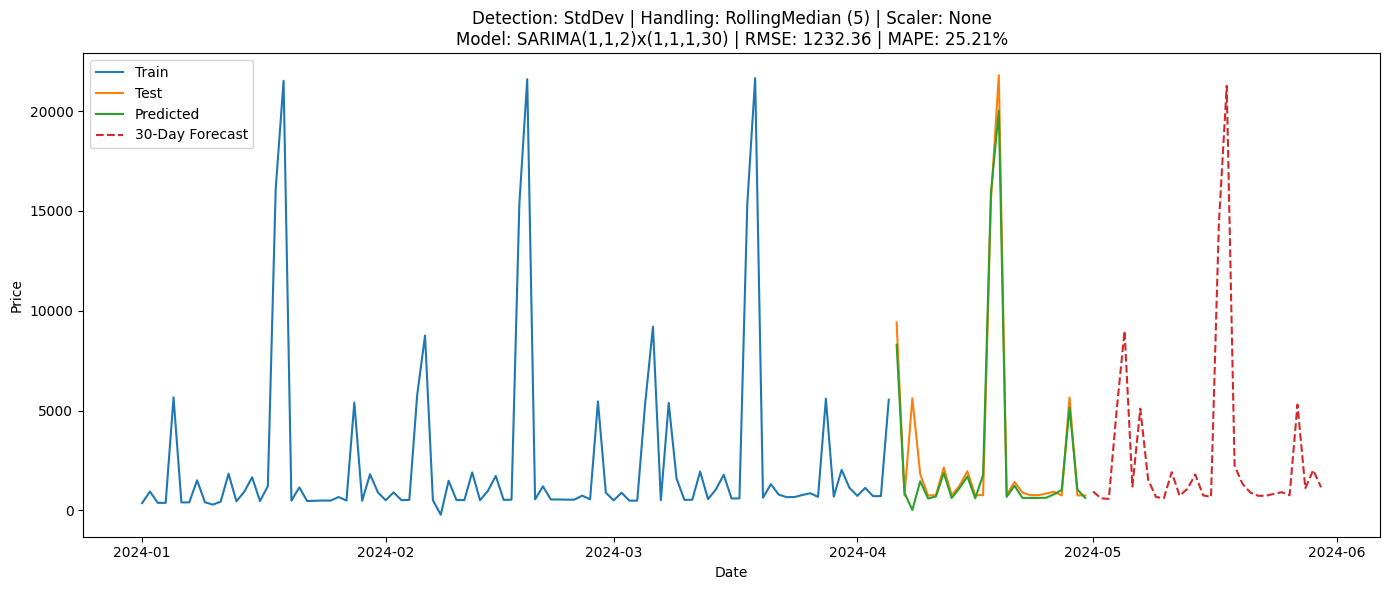

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# --- Outlier Detection ---
def detect_outliers_std(series, threshold=2.5):
    mean = series.mean()
    std = series.std()
    return abs(series - mean) > threshold * std

# --- Outlier Handling ---
def handle_outliers_rolling_median(series, outliers, window=5):
    rolling_median = series.rolling(window=window, center=True).median()
    series_corrected = series.copy()
    series_corrected[outliers] = rolling_median[outliers]
    return series_corrected.fillna(method='bfill').fillna(method='ffill')

# --- MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero]))

# --- Data ---
series = data['Price'].copy()
outliers = detect_outliers_std(series)
cleaned_series = handle_outliers_rolling_median(series, outliers, window=5)

# --- Train/Test Split ---
train_size = int(len(cleaned_series) * 0.8)
train = cleaned_series[:train_size]
test = cleaned_series[train_size:]
train_index = data.index[:train_size]
test_index = data.index[train_size:]
future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30)

# --- Fit SARIMA ---
order = (1, 1, 2)
seasonal_order = (1, 1, 1, 30)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# --- Forecasting ---
pred_test = model.forecast(steps=len(test))
forecast_30 = model.forecast(steps=len(test) + 30)[-30:]

# --- Metrics ---
rmse = sqrt(mean_squared_error(test, pred_test))
mape = mean_absolute_percentage_error(test, pred_test) * 100
percent_diff = 100 * abs(test.values - pred_test.values) / test.values

# --- Detailed DataFrame Output ---
results_df = pd.DataFrame({
    'Date': test_index,
    'Actual': test.values,
    'Predicted': pred_test.values,
    'Percent Difference (%)': percent_diff
})
forecast_df = pd.DataFrame({
    'Forecast Date': future_index,
    'Forecasted Value': forecast_30.values
})

# --- Print Detailed Summary ---
print("============= MODEL CONFIGURATION =============")
print("Model: SARIMA(1,1,2)x(1,1,1,30)")
print("Outlier Detection: StdDev (threshold=2.5)")
print("Outlier Handling: RollingMedian (window=5)")
print("Scaler: None")
print(f"Train Size: {train_size}")
print(f"Test Size: {len(test)}")
print("\n============= TEST METRICS =============")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

print("\n============= TEST SET RESULTS (Sample) =============")
print(results_df.head(25).to_string(index=False))

print("\n============= 30-DAY FORECAST =============")
print(forecast_df.to_string(index=False))

# --- Optional: Save to Excel or CSV ---
# results_df.to_csv("sarima_test_results.csv", index=False)
# forecast_df.to_csv("sarima_30day_forecast.csv", index=False)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(train_index, train, label='Train')
plt.plot(test_index, test, label='Test')
plt.plot(test_index, pred_test, label='Predicted')
plt.plot(future_index, forecast_30, label='30-Day Forecast', linestyle='--')
plt.title(f"Detection: StdDev | Handling: RollingMedian (5) | Scaler: None\n"
          f"Model: SARIMA(1,1,2)x(1,1,1,30) | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

============= MODEL CONFIGURATION =============
Model: SARIMA(3,1,2)x(1,1,1,30)
Outlier Detection: StdDev (threshold=2.5)
Outlier Handling: RollingMedian (window=5)
Scaler: Log Transformation (shifted by 1)
Train Size: 96
Test Size: 25

============= TEST METRICS =============
RMSE: 0.31
MAPE: 2.46%

============= TEST SET RESULTS (Sample) =============
      Date       Actual    Predicted  Percent Difference (%)
2024-04-06  9412.404261  7458.826904                2.542134
2024-04-07   733.526680   681.482630                1.113604
2024-04-08  5614.522000  1595.804961               14.566056
2024-04-09  1819.139974  1554.150765                2.096015
2024-04-10   741.197571   640.511189                2.205709
2024-04-11   757.623320   817.898656                1.152905
2024-04-12  2144.584957  2066.864101                0.480970
2024-04-13   759.390804   717.758283                0.848791
2024-04-14  1230.413811  1382.508064                1.636604
2024-04-15  1958.443412  1919.1818

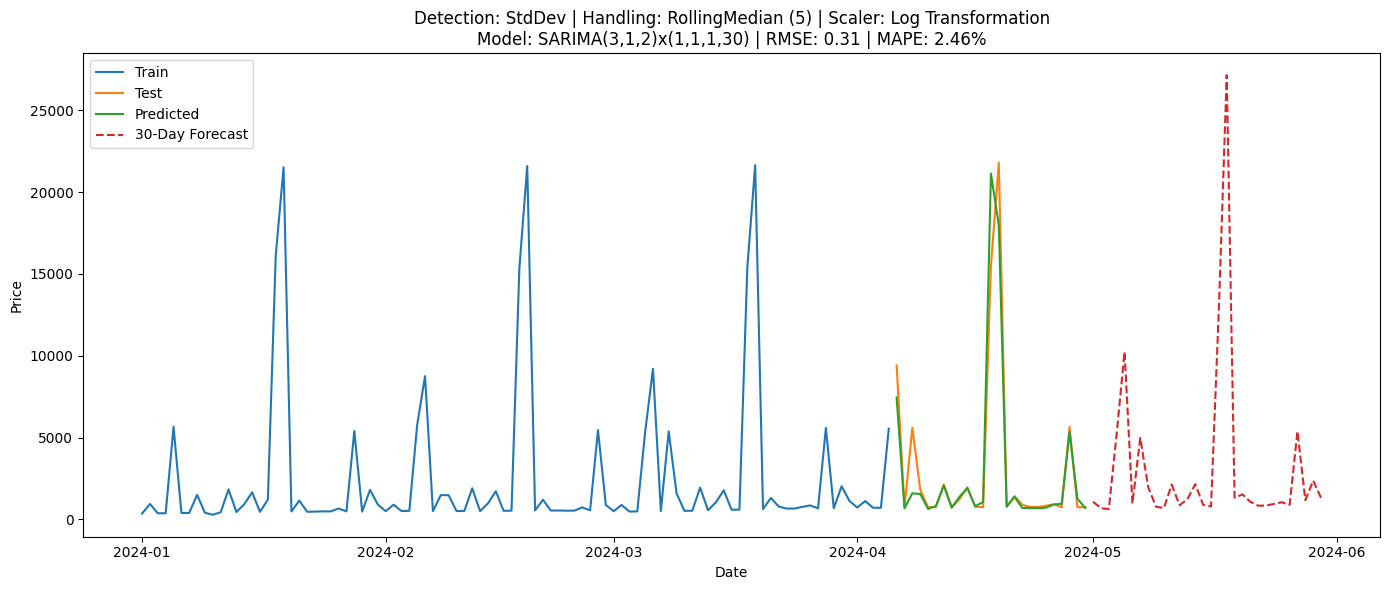

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# --- Outlier Detection ---
def detect_outliers_std(series, threshold=2.5):
    mean = series.mean()
    std = series.std()
    return abs(series - mean) > threshold * std

# --- Outlier Handling ---
def handle_outliers_rolling_median(series, outliers, window=5):
    rolling_median = series.rolling(window=window, center=True).median()
    series_corrected = series.copy()
    series_corrected[outliers] = rolling_median[outliers]
    return series_corrected.fillna(method='bfill').fillna(method='ffill')

# --- MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero]))

# --- Data ---
series = data['Price'].copy()

# --- Log Transformation (Shifted to avoid issues with zero/negative values) ---
series_log = np.log(series + 1)  # Apply log transformation with shift of 1

# --- Outlier Detection ---
outliers = detect_outliers_std(series_log)
cleaned_series = handle_outliers_rolling_median(series_log, outliers, window=5)

# --- Train/Test Split ---
train_size = int(len(cleaned_series) * 0.8)
train = cleaned_series[:train_size]
test = cleaned_series[train_size:]
train_index = data.index[:train_size]
test_index = data.index[train_size:]
future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30)

# --- Fit SARIMA ---
order = (3, 1, 2)
seasonal_order = (1, 1, 1, 30)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# --- Forecasting ---
pred_test = model.forecast(steps=len(test))
forecast_30 = model.forecast(steps=len(test) + 30)[-30:]

# --- Inverse Log Transformation (to return to the original scale) ---
pred_test_original = np.exp(pred_test) - 1
forecast_30_original = np.exp(forecast_30) - 1

# --- Metrics ---
rmse = sqrt(mean_squared_error(test, pred_test))
mape = mean_absolute_percentage_error(test, pred_test) * 100
percent_diff = 100 * abs(test.values - pred_test.values) / test.values

# --- Detailed DataFrame Output ---
results_df = pd.DataFrame({
    'Date': test_index,
    'Actual': np.exp(test.values) - 1,  # Inverse log for actuals as well
    'Predicted': pred_test_original,
    'Percent Difference (%)': percent_diff
})
forecast_df = pd.DataFrame({
    'Forecast Date': future_index,
    'Forecasted Value': forecast_30_original
})

# --- Print Detailed Summary ---
print("============= MODEL CONFIGURATION =============")
print("Model: SARIMA(3,1,2)x(1,1,1,30)")
print("Outlier Detection: StdDev (threshold=2.5)")
print("Outlier Handling: RollingMedian (window=5)")
print("Scaler: Log Transformation (shifted by 1)")
print(f"Train Size: {train_size}")
print(f"Test Size: {len(test)}")
print("\n============= TEST METRICS =============")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

print("\n============= TEST SET RESULTS (Sample) =============")
print(results_df.head(25).to_string(index=False))

print("\n============= 30-DAY FORECAST =============")
print(forecast_df.to_string(index=False))

# --- Optional: Save to Excel or CSV ---
# results_df.to_csv("sarima_test_results.csv", index=False)
# forecast_df.to_csv("sarima_30day_forecast.csv", index=False)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(train_index, np.exp(train) - 1, label='Train')  # Inverse log for train
plt.plot(test_index, np.exp(test) - 1, label='Test')  # Inverse log for test
plt.plot(test_index, np.exp(pred_test) - 1, label='Predicted')  # Inverse log for predictions
plt.plot(future_index, np.exp(forecast_30) - 1, label='30-Day Forecast', linestyle='--')  # Inverse log for forecast
plt.title(f"Detection: StdDev | Handling: RollingMedian (5) | Scaler: Log Transformation\n"
          f"Model: SARIMA(3,1,2)x(1,1,1,30) | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:

# # --- Save Preprocessed Data ---
# preprocessed_data = pd.DataFrame({
#     'UsageStartDate': data.index[:train_size],  # Ensure this matches the cleaned data's length
#     'PricingPreTaxTotal': np.exp(cleaned_series[:train_size]) - 1  # Use cleaned series up to train_size
# })

# # Save to CSV (or Excel)
# preprocessed_data.to_csv('preprocessed_data.csv', index=False)  # Save to CSV
# # OR
# # preprocessed_data.to_excel('preprocessed_data.xlsx', index=False)  # Save to Excel

# # --- Save Model Using joblib ---
# joblib.dump(model, 'sarima_model.joblib')  # Save the SARIMA model

# # --- Save Model in HDF5 Format ---
# with h5py.File('sarima_model.h5', 'w') as f:
#     f.create_dataset('order', data=order)
#     f.create_dataset('seasonal_order', data=seasonal_order)
#     f.create_dataset('coefficients', data=model.params)

============= MODEL CONFIGURATION =============
Model: SARIMA(3,1,2)x(1,1,1,30)
Outlier Detection: StdDev (threshold=2.5)
Outlier Handling: RollingMedian (window=5)
Scaler: Log Transformation (shifted by 1)
Train Size: 96
Test Size: 25

============= TEST METRICS =============
RMSE: 0.31
MAPE: 2.46%

============= TEST SET RESULTS (Sample) =============
      Date       Actual    Predicted  Percent Difference (%)
2024-04-06  9412.404261  7458.826904                2.542134
2024-04-07   733.526680   681.482630                1.113604
2024-04-08  5614.522000  1595.804961               14.566056
2024-04-09  1819.139974  1554.150765                2.096015
2024-04-10   741.197571   640.511189                2.205709
2024-04-11   757.623320   817.898656                1.152905
2024-04-12  2144.584957  2066.864101                0.480970
2024-04-13   759.390804   717.758283                0.848791
2024-04-14  1230.413811  1382.508064                1.636604
2024-04-15  1958.443412  1919.1818

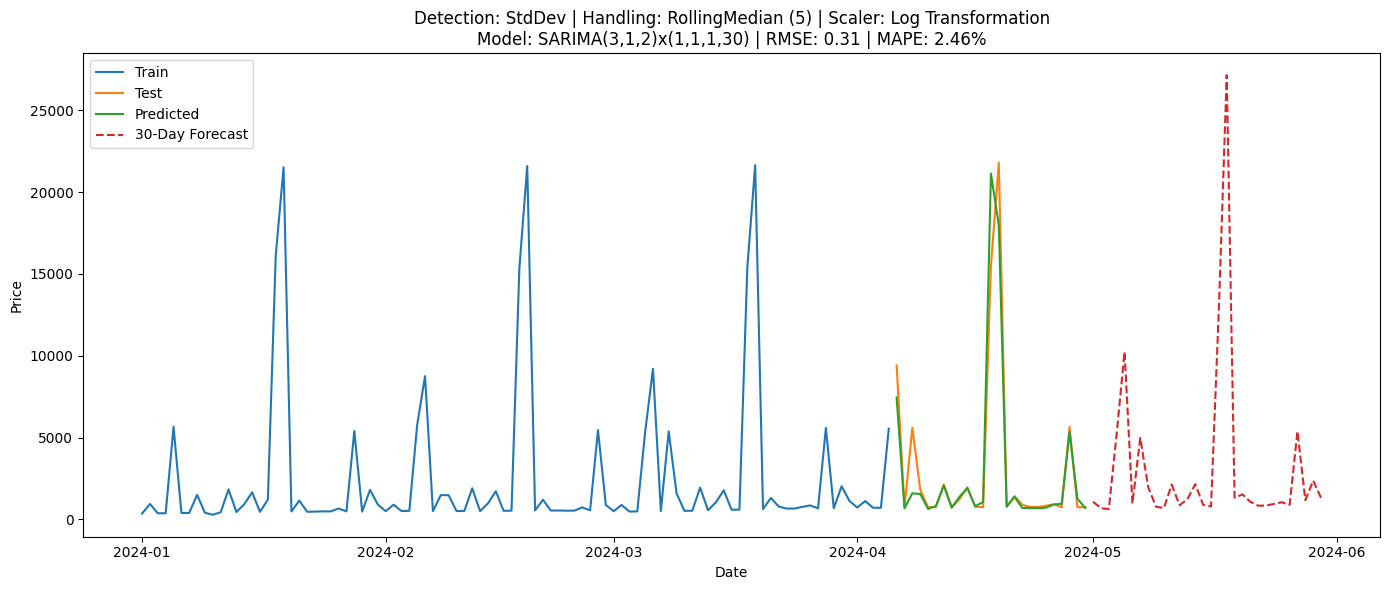

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# --- Outlier Detection ---
def detect_outliers_std(series, threshold=2.5):
    mean = series.mean()
    std = series.std()
    return abs(series - mean) > threshold * std

# --- Outlier Handling ---
def handle_outliers_rolling_median(series, outliers, window=5):
    rolling_median = series.rolling(window=window, center=True).median()
    series_corrected = series.copy()
    series_corrected[outliers] = rolling_median[outliers]
    return series_corrected.fillna(method='bfill').fillna(method='ffill')

# --- MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero]))

# --- Data ---
series = data['Price'].copy()

# --- Log Transformation (Shifted to avoid issues with zero/negative values) ---
series_log = np.log(series + 1)

# --- Outlier Detection ---
outliers = detect_outliers_std(series_log)
cleaned_series = handle_outliers_rolling_median(series_log, outliers, window=5)

# --- Train/Test Split ---
train_size = int(len(cleaned_series) * 0.8)
train = cleaned_series[:train_size]
test = cleaned_series[train_size:]
train_index = data.index[:train_size]
test_index = data.index[train_size:]
future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30)

# --- Fit SARIMA ---
order = (3, 1, 2)
seasonal_order = (1, 1, 1, 30)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# --- Save Model ---
with open('sarima_model.sav', 'wb') as f:
    pickle.dump(model, f)

# --- Forecasting ---
pred_test = model.forecast(steps=len(test))
forecast_30 = model.forecast(steps=len(test) + 30)[-30:]

# --- Inverse Log Transformation ---
pred_test_original = np.exp(pred_test) - 1
forecast_30_original = np.exp(forecast_30) - 1

# --- Metrics ---
rmse = sqrt(mean_squared_error(test, pred_test))
mape = mean_absolute_percentage_error(test, pred_test) * 100
percent_diff = 100 * abs(test.values - pred_test.values) / test.values

# --- Detailed DataFrame Output ---
results_df = pd.DataFrame({
    'Date': test_index,
    'Actual': np.exp(test.values) - 1,
    'Predicted': pred_test_original,
    'Percent Difference (%)': percent_diff
})
forecast_df = pd.DataFrame({
    'Forecast Date': future_index,
    'Forecasted Value': forecast_30_original
})

# --- Print Summary ---
print("============= MODEL CONFIGURATION =============")
print("Model: SARIMA(3,1,2)x(1,1,1,30)")
print("Outlier Detection: StdDev (threshold=2.5)")
print("Outlier Handling: RollingMedian (window=5)")
print("Scaler: Log Transformation (shifted by 1)")
print(f"Train Size: {train_size}")
print(f"Test Size: {len(test)}")

print("\n============= TEST METRICS =============")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

print("\n============= TEST SET RESULTS (Sample) =============")
print(results_df.head(25).to_string(index=False))

print("\n============= 30-DAY FORECAST =============")
print(forecast_df.to_string(index=False))

# --- Optional: Save Results to File ---
# results_df.to_csv("sarima_test_results.csv", index=False)
# forecast_df.to_csv("sarima_30day_forecast.csv", index=False)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(train_index, np.exp(train) - 1, label='Train')
plt.plot(test_index, np.exp(test) - 1, label='Test')
plt.plot(test_index, pred_test_original, label='Predicted')
plt.plot(future_index, forecast_30_original, label='30-Day Forecast', linestyle='--')
plt.title(f"Detection: StdDev | Handling: RollingMedian (5) | Scaler: Log Transformation\n"
          f"Model: SARIMA(3,1,2)x(1,1,1,30) | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


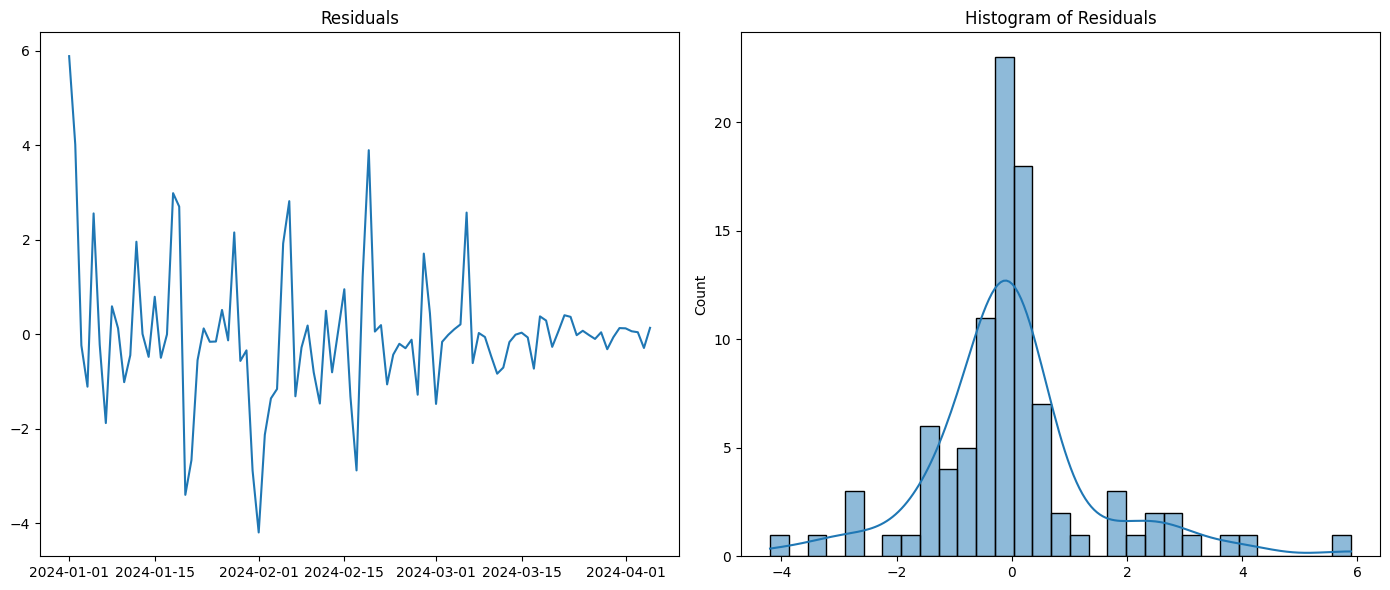

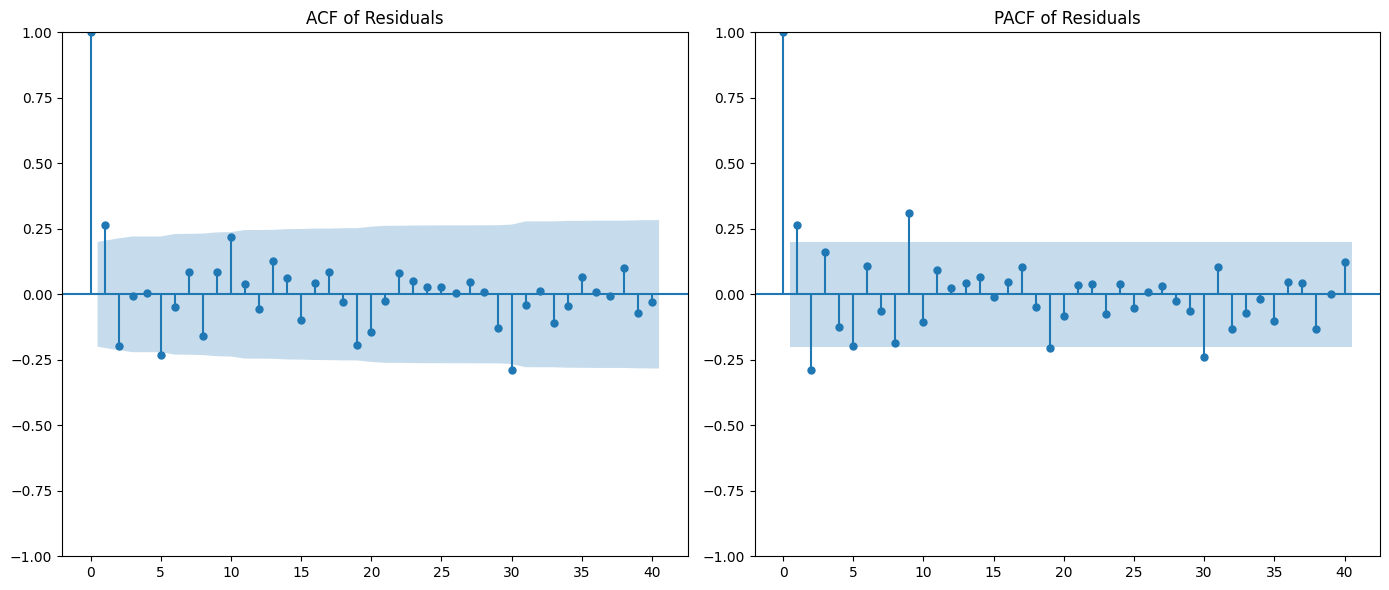

Normality Test (D'Agostino): Statistic=22.4372, p-value=0.0000

Ljung-Box Test (p-value for 30 lags):
      lb_stat  lb_pvalue
30  54.233697   0.004329


In [11]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import normaltest

# --- Residuals Analysis ---
residuals = model.resid

# 1. Plot Residuals
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.plot(residuals)
plt.title('Residuals')

# 2. Plot Histogram of Residuals
plt.subplot(122)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()

# --- ACF and PACF of Residuals ---
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')

plt.subplot(122)
plot_pacf(residuals, lags=40, ax=plt.gca())
plt.title('PACF of Residuals')
plt.tight_layout()
plt.show()

# --- Normality Test of Residuals (D'Agostino and Pearson's test) ---
stat, p_value = normaltest(residuals)
print(f"Normality Test (D'Agostino): Statistic={stat:.4f}, p-value={p_value:.4f}")

# --- Ljung-Box Test for Autocorrelation ---
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box = acorr_ljungbox(residuals, lags=[30], return_df=True)
print("\nLjung-Box Test (p-value for 30 lags):")
print(ljung_box)

# --- Plot ACF/PACF Residuals


# Other practical work

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import winsorize
from math import sqrt

# --- Load Data ---
series = data['Price'].copy()
series_log = np.log(series + 1)

# --- Outlier Detection Methods ---
def detect_outliers_std(series, threshold=2.5):
    mean = series.mean()
    std = series.std()
    return abs(series - mean) > threshold * std

def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))

def detect_outliers_zscore(series, threshold=3):
    z_scores = (series - series.mean()) / series.std()
    return abs(z_scores) > threshold

def detect_outliers_modified_zscore(series, threshold=3.5):
    median = series.median()
    mad = np.median(np.abs(series - median))
    modified_z_scores = 0.6745 * (series - median) / mad
    return abs(modified_z_scores) > threshold

# --- Outlier Handling (Interpolation) ---
def handle_outliers_interpolation(series, outliers):
    series_corrected = series.copy()
    series_corrected[outliers] = np.nan
    return series_corrected.interpolate(method='linear', limit_direction='both')

# --- MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero]))

# --- Run detection methods ---
outlier_methods = {
    'StdDev': detect_outliers_std,
    'IQR': detect_outliers_iqr,
    'Z-Score': detect_outliers_zscore,
    'Modified Z-Score': detect_outliers_modified_zscore
}

for name, method in outlier_methods.items():
    outliers = method(series_log)
    cleaned_series_interp = handle_outliers_interpolation(series_log, outliers)

    # After interpolation, check if any values are still outliers
    remaining_outliers_interp = method(cleaned_series_interp).sum()

    # If there are still outliers, replace them with the median or mean
    if remaining_outliers_interp > 0:
        median_value = cleaned_series_interp.median()
        cleaned_series_interp[method(cleaned_series_interp)] = median_value
        remaining_outliers_interp = method(cleaned_series_interp).sum()

    print(f"Outlier Detection Method: {name}")
    print(f"Initial Anomalies Detected: {outliers.sum()}")
    print(f"Remaining Outliers after Interpolation: {remaining_outliers_interp}")

    # --- Train/Test Split ---
    train_size = int(len(cleaned_series_interp) * 0.8)
    train = cleaned_series_interp[:train_size]
    test = cleaned_series_interp[train_size:]
    train_index = data.index[:train_size]
    test_index = data.index[train_size:]
    future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30)

    # --- Fit SARIMA ---
    model = SARIMAX(train, order=(1, 1, 2), seasonal_order=(1, 1, 1, 30),
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

    # --- Forecasting ---
    pred_test = model.forecast(steps=len(test))
    forecast_30 = model.forecast(steps=len(test) + 30)[-30:]

    # --- Inverse Log Transformation ---
    pred_test_original = np.exp(pred_test) - 1
    forecast_30_original = np.exp(forecast_30) - 1

    # --- Metrics ---
    rmse = sqrt(mean_squared_error(test, pred_test))
    mape = mean_absolute_percentage_error(test, pred_test) * 100

    print(f"RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    print("===========================\n")

    # --- Plot ---
    plt.figure(figsize=(12, 4))
    plt.plot(train_index, np.exp(train) - 1, label='Train')
    plt.plot(test_index, np.exp(test) - 1, label='Test')
    plt.plot(test_index, pred_test_original, label='Predicted')
    plt.plot(future_index, forecast_30_original, label='30-Day Forecast', linestyle='--')
    plt.title(f"Outlier Method: {name} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# --- Outlier Detection ---
def detect_outliers_std(series, threshold=2.0):
    mean = series.mean()
    std = series.std()
    return abs(series - mean) > threshold * std

def detect_outliers_zscore(series, threshold=2.0):
    z_scores = (series - series.mean()) / series.std()
    return abs(z_scores) > threshold

# --- Hybrid Outlier Handling ---
def handle_outliers_hybrid(series, outliers, window=5):
    percentile_95 = np.percentile(series, 95)
    extreme_spikes = (series > percentile_95) & outliers
    mild_outliers = outliers & ~extreme_spikes

    corrected = series.copy()

    # Interpolate extreme spikes
    corrected[extreme_spikes] = np.nan
    corrected.interpolate(method='linear', inplace=True)

    # Rolling median for mild outliers
    rolling_median = series.rolling(window=window, center=True).median()
    corrected[mild_outliers] = rolling_median[mild_outliers]

    # Fill any remaining NaNs
    return corrected.fillna(method='bfill').fillna(method='ffill')

# --- MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero]))

# --- Parameters ---
OUTLIER_METHOD = 'zscore'  # Options: 'std', 'zscore'
SARIMA_ORDER = (1, 1, 2)
SEASONAL_ORDER = (1, 1, 1, 30)

# --- Load & Prepare Data ---
# Replace this with your actual data source
# data = pd.read_csv("your_data.csv", parse_dates=True, index_col="Date")
series = data['Price'].copy()

# --- Outlier Detection + Handling ---
if OUTLIER_METHOD == 'std':
    outliers = detect_outliers_std(series, threshold=2.0)
elif OUTLIER_METHOD == 'zscore':
    outliers = detect_outliers_zscore(series, threshold=2.0)

cleaned_series = handle_outliers_hybrid(series, outliers, window=5)

# --- Train/Test Split ---
train_size = int(len(cleaned_series) * 0.8)
train = cleaned_series[:train_size]
test = cleaned_series[train_size:]
train_index = data.index[:train_size]
test_index = data.index[train_size:]
future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30)

# --- Fit SARIMA ---
model = SARIMAX(train, order=SARIMA_ORDER, seasonal_order=SEASONAL_ORDER,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# --- Forecasting ---
pred_test = model.forecast(steps=len(test))
forecast_30 = model.forecast(steps=len(test) + 30)[-30:]

# --- Metrics ---
rmse = sqrt(mean_squared_error(test, pred_test))
mape = mean_absolute_percentage_error(test, pred_test) * 100
percent_diff = 100 * abs(test.values - pred_test.values) / test.values

# --- DataFrames ---
results_df = pd.DataFrame({
    'Date': test_index,
    'Actual': test.values,
    'Predicted': pred_test.values,
    'Percent Difference (%)': percent_diff
})
forecast_df = pd.DataFrame({
    'Forecast Date': future_index,
    'Forecasted Value': forecast_30.values
})

# --- Print Summary ---
print("============= MODEL CONFIGURATION =============")
print(f"Model: SARIMA{SARIMA_ORDER}x{SEASONAL_ORDER}")
print(f"Outlier Detection: {OUTLIER_METHOD}")
print("Outlier Handling: Hybrid (95th Interpolation + RollingMedian(5))")
print("Scaler: None")
print(f"Train Size: {train_size}")
print(f"Test Size: {len(test)}")

print("\n============= TEST METRICS =============")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

print("\n============= TEST SET RESULTS (Sample) =============")
print(results_df.head(25).to_string(index=False))

print("\n============= 30-DAY FORECAST =============")
print(forecast_df.to_string(index=False))

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(train_index, train, label='Train')
plt.plot(test_index, test, label='Test')
plt.plot(test_index, pred_test, label='Predicted')
plt.plot(future_index, forecast_30, label='30-Day Forecast', linestyle='--')
plt.title(f"Detection: {OUTLIER_METHOD} | Handling: Hybrid | Scaler: None\n"
          f"Model: SARIMA{SARIMA_ORDER}x{SEASONAL_ORDER} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# --- Outlier Detection ---
def detect_outliers_std(series, threshold=2.0):
    mean = series.mean()
    std = series.std()
    return abs(series - mean) > threshold * std

def detect_outliers_zscore(series, threshold=2.0):
    z_scores = (series - series.mean()) / series.std()
    return abs(z_scores) > threshold

# --- Hybrid Outlier Handling ---
def handle_outliers_hybrid(series, outliers, window=5):
    percentile_95 = np.percentile(series, 99)
    extreme_spikes = (series > percentile_95) & outliers
    mild_outliers = outliers & ~extreme_spikes

    corrected = series.copy()

    # Interpolate extreme spikes
    corrected[extreme_spikes] = np.nan
    corrected.interpolate(method='linear', inplace=True)

    # Rolling median for mild outliers
    rolling_median = series.rolling(window=window, center=True).median()
    corrected[mild_outliers] = rolling_median[mild_outliers]

    # Fill any remaining NaNs
    return corrected.fillna(method='bfill').fillna(method='ffill')

# --- MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero]))

# --- Parameters ---
OUTLIER_METHOD = 'std'  # Options: 'std', 'zscore'
SARIMA_ORDER = (1, 1, 2)
SEASONAL_ORDER = (1, 1, 1, 30)

# --- Load & Prepare Data ---
# Replace this with your actual data source
# data = pd.read_csv("your_data.csv", parse_dates=True, index_col="Date")
series = data['Price'].copy()

# --- Apply Log Transformation ---
series_log = np.log(series+1)

# --- Outlier Detection + Handling ---
if OUTLIER_METHOD == 'std':
    outliers = detect_outliers_std(series_log, threshold=2.0)
elif OUTLIER_METHOD == 'zscore':
    outliers = detect_outliers_zscore(series_log, threshold=2.0)

cleaned_series_log = handle_outliers_hybrid(series_log, outliers, window=5)

# --- Train/Test Split ---
train_size = int(len(cleaned_series_log) * 0.8)
train_log = cleaned_series_log[:train_size]
test_log = cleaned_series_log[train_size:]
train_index = data.index[:train_size]
test_index = data.index[train_size:]
future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30)

# --- Fit SARIMA ---
model = SARIMAX(train_log, order=SARIMA_ORDER, seasonal_order=SEASONAL_ORDER,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# --- Forecasting ---
pred_test_log = model.forecast(steps=len(test_log))
forecast_30_log = model.forecast(steps=len(test_log) + 30)[-30:]

# --- Inverse Log Transformation ---
pred_test = np.exp(pred_test_log)
forecast_30 = np.exp(forecast_30_log)

# --- Metrics ---
rmse = sqrt(mean_squared_error(np.exp(test_log), pred_test))
mape = mean_absolute_percentage_error(np.exp(test_log), pred_test) * 100
percent_diff = 100 * abs(np.exp(test_log).values - pred_test.values) / np.exp(test_log).values

# --- DataFrames ---
results_df = pd.DataFrame({
    'Date': test_index,
    'Actual': np.exp(test_log).values,
    'Predicted': pred_test.values,
    'Percent Difference (%)': percent_diff
})
forecast_df = pd.DataFrame({
    'Forecast Date': future_index,
    'Forecasted Value': forecast_30.values
})

# --- Print Summary ---
print("============= MODEL CONFIGURATION =============")
print(f"Model: SARIMA{SARIMA_ORDER}x{SEASONAL_ORDER}")
print(f"Outlier Detection: {OUTLIER_METHOD}")
print("Outlier Handling: Hybrid (95th Interpolation + RollingMedian(5))")
print("Scaler: Log Transformation")
print(f"Train Size: {train_size}")
print(f"Test Size: {len(test)}")

print("\n============= TEST METRICS =============")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

print("\n============= TEST SET RESULTS (Sample) =============")
print(results_df.head(25).to_string(index=False))

print("\n============= 30-DAY FORECAST =============")
print(forecast_df.to_string(index=False))

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(train_index, np.exp(train_log), label='Train')
plt.plot(test_index, np.exp(test_log), label='Test')
plt.plot(test_index, pred_test, label='Predicted')
plt.plot(future_index, forecast_30, label='30-Day Forecast', linestyle='--')
plt.title(f"Detection: {OUTLIER_METHOD} | Handling: Hybrid | Scaler: Log Transformation\n"
          f"Model: SARIMA{SARIMA_ORDER}x{SEASONAL_ORDER} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

# --- Outlier Detection ---
def detect_outliers_zscore(series, threshold=2.0):
    z_scores = (series - series.mean()) / series.std()
    return abs(z_scores) > threshold

# --- Handle Only >95th Percentile Spikes with Interpolation ---
def handle_extreme_spikes_only(series, outliers):
    percentile_95 = np.percentile(series, 99)
    extreme_spikes = (series > percentile_95) & outliers
    corrected = series.copy()
    corrected[extreme_spikes] = np.nan
    corrected.interpolate(method='linear', inplace=True)
    return corrected.fillna(method='bfill').fillna(method='ffill')

# --- MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero]))

# --- Data ---
series = data['Price'].copy()

# --- Log Transformation (Shifted to avoid issues with zero/negative values) ---
series_log = np.log(series + 1)

# --- Outlier Detection ---
outliers = detect_outliers_zscore(series_log)
cleaned_series = handle_extreme_spikes_only(series_log, outliers)

# --- Train/Test Split ---
train_size = int(len(cleaned_series) * 0.8)
train = cleaned_series[:train_size]
test = cleaned_series[train_size:]
train_index = data.index[:train_size]
test_index = data.index[train_size:]
future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30)

# --- Fit SARIMA ---
order = (1, 1, 2)
seasonal_order = (1, 1, 1, 30)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# --- Forecasting ---
pred_test = model.forecast(steps=len(test))
forecast_30 = model.forecast(steps=len(test) + 30)[-30:]

# --- Inverse Log Transformation (to return to the original scale) ---
pred_test_original = np.exp(pred_test) - 1
forecast_30_original = np.exp(forecast_30) - 1

# --- Metrics ---
rmse = sqrt(mean_squared_error(test, pred_test))
mape = mean_absolute_percentage_error(test, pred_test) * 100
percent_diff = 100 * abs(test.values - pred_test.values) / test.values

# --- Detailed DataFrame Output ---
results_df = pd.DataFrame({
    'Date': test_index,
    'Actual': np.exp(test.values) - 1,  # Inverse log for actuals
    'Predicted': pred_test_original,
    'Percent Difference (%)': percent_diff
})
forecast_df = pd.DataFrame({
    'Forecast Date': future_index,
    'Forecasted Value': forecast_30_original
})

# --- Print Detailed Summary ---
print("============= MODEL CONFIGURATION =============")
print("Model: SARIMA(1,1,2)x(1,1,1,30)")
print("Outlier Detection: Z-score (threshold=2.0)")
print("Outlier Handling: Interpolation (Only >95th percentile)")
print("Scaler: Log Transformation (shifted by 1)")
print(f"Train Size: {train_size}")
print(f"Test Size: {len(test)}")
print("\n============= TEST METRICS =============")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

print("\n============= TEST SET RESULTS (Sample) =============")
print(results_df.head(25).to_string(index=False))

print("\n============= 30-DAY FORECAST =============")
print(forecast_df.to_string(index=False))

# --- Optional: Save to Excel or CSV ---
# results_df.to_csv("sarima_test_results.csv", index=False)
# forecast_df.to_csv("sarima_30day_forecast.csv", index=False)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(train_index, np.exp(train) - 1, label='Train')  # Inverse log for train
plt.plot(test_index, np.exp(test) - 1, label='Test')  # Inverse log for test
plt.plot(test_index, np.exp(pred_test) - 1, label='Predicted')  # Inverse log for predictions
plt.plot(future_index, np.exp(forecast_30) - 1, label='30-Day Forecast', linestyle='--')  # Inverse log for forecast
plt.title(f"Detection: Z-Score | Handling: >95th Interpolation | Scaler: Log Transformation\n"
          f"Model: SARIMA(1,1,2)x(1,1,1,30) | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats.mstats import winsorize

# --- Outlier Detection (Optional) ---
def detect_outliers_zscore(series, threshold=2.0):
    z_scores = (series - series.mean()) / series.std()
    return abs(z_scores) > threshold

# --- Outlier Handling: Winsorization (5th and 95th percentiles) ---
def handle_extreme_spikes_winsor(series, limits=(0.05, 0.05)):
    winsorized_data = winsorize(series, limits=limits)
    return pd.Series(winsorized_data, index=series.index)

# --- MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero]))

# --- Data ---
series = data['Price'].copy()

# --- Log Transformation (Shifted to avoid issues with zero/negative values) ---
series_log = np.log(series + 1)

# --- Outlier Handling with Winsorization ---
cleaned_series = handle_extreme_spikes_winsor(series_log)

# --- Train/Test Split ---
train_size = int(len(cleaned_series) * 0.8)
train = cleaned_series[:train_size]
test = cleaned_series[train_size:]
train_index = data.index[:train_size]
test_index = data.index[train_size:]
future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30)

# --- Fit SARIMA ---
order = (1, 1, 2)
seasonal_order = (1, 1, 1, 30)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# --- Forecasting ---
pred_test = model.forecast(steps=len(test))
forecast_30 = model.forecast(steps=len(test) + 30)[-30:]

# --- Inverse Log Transformation ---
pred_test_original = np.exp(pred_test) - 1
forecast_30_original = np.exp(forecast_30) - 1

# --- Metrics ---
rmse = sqrt(mean_squared_error(test, pred_test))
mape = mean_absolute_percentage_error(test, pred_test) * 100
percent_diff = 100 * abs(test.values - pred_test.values) / test.values

# --- Detailed DataFrame Output ---
results_df = pd.DataFrame({
    'Date': test_index,
    'Actual': np.exp(test.values) - 1,
    'Predicted': pred_test_original,
    'Percent Difference (%)': percent_diff
})
forecast_df = pd.DataFrame({
    'Forecast Date': future_index,
    'Forecasted Value': forecast_30_original
})

# --- Print Summary ---
print("============= MODEL CONFIGURATION =============")
print("Model: SARIMA(1,1,2)x(1,1,1,30)")
print("Outlier Detection: None (Winsorization applied directly)")
print("Outlier Handling: Winsorization (5%, 95%)")
print("Scaler: Log Transformation (shifted by 1)")
print(f"Train Size: {train_size}")
print(f"Test Size: {len(test)}")
print("\n============= TEST METRICS =============")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

print("\n============= TEST SET RESULTS (Sample) =============")
print(results_df.head(25).to_string(index=False))

print("\n============= 30-DAY FORECAST =============")
print(forecast_df.to_string(index=False))

# --- Optional: Save Output ---
# results_df.to_csv("sarima_test_results_winsor_5_95.csv", index=False)
# forecast_df.to_csv("sarima_30day_forecast_winsor_5_95.csv", index=False)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(train_index, np.exp(train) - 1, label='Train')
plt.plot(test_index, np.exp(test) - 1, label='Test')
plt.plot(test_index, pred_test_original, label='Predicted')
plt.plot(future_index, forecast_30_original, label='30-Day Forecast', linestyle='--')
plt.title(f"Handling: Winsorization (5%, 95%) | Scaler: Log Transformation\n"
          f"Model: SARIMA(1,1,2)x(1,1,1,30) | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# --- Outlier Detection: Isolation Forest ---
def detect_outliers_isolation_forest(series, contamination=0.05, random_state=42):
    not_nan_mask = ~series.isna()
    series_nonan = series[not_nan_mask].values.reshape(-1, 1)
    model = IsolationForest(contamination=contamination, random_state=random_state)
    preds = model.fit_predict(series_nonan)
    outlier_mask = pd.Series(False, index=series.index)
    outlier_mask[not_nan_mask] = preds == -1
    return outlier_mask

# --- Outlier Handling: Rolling Median ---
def handle_outliers_with_rolling_median(series, outliers, window=5):
    corrected = series.copy()
    corrected[outliers] = np.nan
    rolling_median = corrected.rolling(window=window, center=True, min_periods=1).median()
    corrected[outliers] = rolling_median[outliers]
    return corrected.fillna(method='bfill').fillna(method='ffill')

# --- MAPE ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero]))

# --- Data (replace this with your actual data loading logic) ---
# Example: data = pd.read_csv("your_data.csv", parse_dates=['Date'], index_col='Date')
series = data['Price'].copy()

# --- Log Transformation (shifted to avoid log(0)) ---
series_log = np.log(series + 1)

# --- Outlier Detection ---
outliers = detect_outliers_isolation_forest(series_log)

# --- Outlier Handling ---
cleaned_series = handle_outliers_with_rolling_median(series_log, outliers, window=5)

# --- Train/Test Split ---
train_size = int(len(cleaned_series) * 0.8)
train = cleaned_series[:train_size]
test = cleaned_series[train_size:]
train_index = data.index[:train_size]
test_index = data.index[train_size:]
future_index = pd.date_range(start=test_index[-1] + pd.Timedelta(days=1), periods=30)

# --- Fit SARIMA Model ---
order = (3, 1, 2)
seasonal_order = (1, 1, 1, 30)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# --- Forecasting ---
pred_test = model.forecast(steps=len(test))
forecast_30 = model.forecast(steps=len(test) + 30)[-30:]

# --- Inverse Log Transformation ---
pred_test_original = np.exp(pred_test) - 1
forecast_30_original = np.exp(forecast_30) - 1

# --- Metrics ---
rmse = sqrt(mean_squared_error(test, pred_test))
mape = mean_absolute_percentage_error(test, pred_test) * 100
percent_diff = 100 * abs(test.values - pred_test.values) / test.values

# --- Detailed Output ---
results_df = pd.DataFrame({
    'Date': test_index,
    'Actual': np.exp(test.values) - 1,
    'Predicted': pred_test_original,
    'Percent Difference (%)': percent_diff
})
forecast_df = pd.DataFrame({
    'Forecast Date': future_index,
    'Forecasted Value': forecast_30_original
})

# --- Print Summary ---
print("============= MODEL CONFIGURATION =============")
print("Model: SARIMA(3,1,2)x(1,1,1,30)")
print("Outlier Detection: Isolation Forest (contamination=0.05)")
print("Outlier Handling: Rolling Median (window=5)")
print("Scaler: Log Transformation (shifted by 1)")
print(f"Train Size: {train_size}")
print(f"Test Size: {len(test)}")
print("\n============= TEST METRICS =============")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

print("\n============= TEST SET RESULTS (Sample) =============")
print(results_df.head(25).to_string(index=False))

print("\n============= 30-DAY FORECAST =============")
print(forecast_df.to_string(index=False))

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(train_index, np.exp(train) - 1, label='Train')
plt.plot(test_index, np.exp(test) - 1, label='Test')
plt.plot(test_index, pred_test_original, label='Predicted')
plt.plot(future_index, forecast_30_original, label='30-Day Forecast', linestyle='--')
plt.title(f"Isolation Forest + Rolling Median | SARIMA(3,1,2)x(1,1,1,30)\nRMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Other Models